In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import glob
import os
import gc
import pickle

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
# import lightgbm as lgb

# from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns

# from scipy.stats import binned_statistic

from functools import partial
from numba import jit

# import tensorflow as tf 
# from tensorflow import keras
# from keras import layers

#path_root = '../input/optiver-realized-volatility-prediction'
#path_data = '../input/optiver-realized-volatility-prediction'
path_data = '/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data'
path_submissions = '/'

target_name = 'target'
scores_folds = {}

/tmp/ipykernel_4929/578927257.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Time Binned Data Gen

In [4]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def diff(list_stock_prices):
    return list_stock_prices.diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def realized_absvol(series_log_return):
    return np.sum(np.abs(series_log_return))

@jit(nopython=True)
def finish_bin(bin_width, bin_sum:float, bin_weight:float, last_val, last_weight, last_time)->float: 
    dt = bin_width - last_time%bin_width
    
    bin_weight += 1.0*last_weight*dt
    bin_sum    += 1.0*last_weight*dt*last_val
    
    return float(bin_sum/(bin_weight + 1e-8))
    
import typing



@jit()
def binned_time_weighted_mean_stat(t, x, w, bin_width, n_bins, n_rows):
    #bin_list = [[]]
    z = np.zeros( (n_rows,n_bins) )
    
    prev_time   = 0
    prev_weight = 0.0
    prev_val    = 0.0
    
    bin_sum = 0.0
    bin_weight = 0.0

    zk  = 0
    zkk = 0
    for k in range(t.shape[0]):
        
        if t[k] < prev_time:
            z[zk, zkk] = float(finish_bin(bin_width, bin_sum, bin_weight, prev_val, prev_weight, prev_time))
            zkk += 1
            
            while zkk < z.shape[1]:
                z[zk, zkk] = prev_val
                zkk += 1
            zk += 1
            zkk = 0
            
            prev_time  = 0
            bin_sum    = 0.0
            bin_weight = 0.0            
            
        if int(t[k]//bin_width) != int(prev_time//bin_width):
            skip_to = t[k]//bin_width - prev_time//bin_width
            
            z[zk, zkk] = float(finish_bin(bin_width, bin_sum, bin_weight, prev_val, prev_weight, prev_time))
            zkk += 1
            
            while zkk < skip_to:
                z[zk, zkk] = prev_val
                zkk += 1
            
            prev_time   = bin_width*(t[k]//bin_width)
            bin_sum = 0.0
            bin_weight = 0.0
        
        bin_sum    += prev_val*prev_weight*(t[k] - prev_time)
        bin_weight +=          prev_weight*(t[k] - prev_time)
        
        prev_time   = t[k]
        prev_val    = x[k]
        prev_weight = w[k]
            
    z[zk, zkk] = finish_bin(bin_width, bin_sum, bin_weight, prev_val, prev_weight, prev_time)
    
    for zkk in range(zkk+1, z.shape[1]):
        z[zk, zkk] = prev_val
                             
    return z


@jit(nopython=True)
def finish_tc_bin(bin_width, bin_sum:float, last_val, prev_time)->float: 
    final_time = bin_width
    
    bin_sum    += last_val/2.0 * ( final_time**2 - prev_time**2 )
    
    return float(bin_sum)
    
@jit()
def binned_tc_time_weighted_mean_stat(t, x, bin_width, n_bins, n_rows):
    #bin_list = [[]]
    z = np.zeros( (n_rows,n_bins) )
    
    prev_time   = 0
    prev_val    = 0.0
    
    bin_sum = 0.0

    zk  = 0
    zkk = 0
    for k in range(t.shape[0]):
        
        if t[k] < prev_time:
            z[zk, zkk] = float(finish_tc_bin(bin_width, bin_sum, prev_val, prev_time))
            zkk += 1
            
            while zkk < z.shape[1]:
                z[zk, zkk] = prev_val
                zkk += 1
            zk += 1
            zkk = 0
            
            prev_time  = 0
            bin_sum    = 0.0
            
        if int(t[k]//bin_width) != int(prev_time//bin_width):
            skip_to = t[k]//bin_width - prev_time//bin_width
            
            z[zk, zkk] = float(finish_tc_bin(bin_width, bin_sum, prev_val, prev_time))
            zkk += 1
            
            while zkk < skip_to:
                z[zk, zkk] = prev_val
                zkk += 1
            
            prev_time   = bin_width*(t[k]//bin_width)
            bin_sum = 0.0
        
        bin_sum    += prev_val*(t[k]**2 - prev_time**2)/2.0
        
        prev_time   = t[k]
        prev_val    = x[k]
            
    z[zk, zkk] = finish_bin(bin_width, bin_sum, prev_val, prev_time)
    
    for zkk in range(zkk+1, z.shape[1]):
        z[zk, zkk] = prev_val
                             
    return z



@jit()
def binned_sum_impulse(t, x, bin_width, n_bins, n_rows):
    z = np.zeros( (n_rows,n_bins) )

    prev_time = 0
    zk  = 0
    for k in range(t.shape[0]):
        
        if t[k] < prev_time:
            zk = zk + 1
            
        z[zk, int(t[k]//bin_width)] += x[k]            
        prev_time = t[k]
    
    return z



def full_book_wap(p0, df, lvl, n_step=62, step_size=1/9):
    p = np.array(p0)
    la2 = np.array(df['log_ask2'])
    la1 = np.array(df['log_ask1'])
    lb1 = np.array(df['log_bid1'])
    lb2 = np.array(df['log_bid2'])
    as2 = np.array(df['ask_size2'])
    as1 = np.array(df['ask_size1'])
    bs1 = np.array(df['bid_size1'])
    bs2 = np.array(df['bid_size2'])
    
    
    s = (-1)**lvl
    for k in range(64):
        ixa2 = 1.0/( 1000*( p - la2 ) )
        ixa1 = 1.0/( 1000*( p - la1 ) )
        ixb1 = 1.0/( 1000*( p - lb1 ) )
        ixb2 = 1.0/( 1000*( p - lb2 ) )

        p = p + step_size * (
              (   ( bs2*ixb2**(lvl+1) + bs1*ixb1**(lvl+1) )
              + s*( as1*ixa1**(lvl+1) + as2*ixa2**(lvl+1) ) )
            / (   ( bs2*ixb2**(lvl+2) + bs1*ixb1**(lvl+2) )
              + s*( as1*ixa1**(lvl+2) + as2*ixa2**(lvl+2) ) ) 
            )/( (lvl + 1) * 1000 )
    return p
   

def full_book_wap_bisect(df, lvl, n_step=22):
    la2 = np.array(df['log_ask2'])
    la1 = np.array(df['log_ask1'])
    lb1 = np.array(df['log_bid1'])
    lb2 = np.array(df['log_bid2'])
    
    as2 = np.array(df['ask_size2'])
    as1 = np.array(df['ask_size1'])
    bs1 = np.array(df['bid_size1'])
    bs2 = np.array(df['bid_size2'])
    
    ub = la1
    lb = lb1
    s0 = ub - lb
    
    s = (-1)**lvl
    for k in range(n_step):
        p = (ub + lb)/2.0
        ixa2 = 1.0/( 1000*( p - la2 ) )
        ixa1 = 1.0/( 1000*( p - la1 ) )
        ixb1 = 1.0/( 1000*( p - lb1 ) )
        ixb2 = 1.0/( 1000*( p - lb2 ) )

        f  = -(   ( bs2*ixb2**(lvl+1) + bs1*ixb1**(lvl+1) )
              + s*( as1*ixa1**(lvl+1) + as2*ixa2**(lvl+1) ) )
        

        dub = - (ub-lb)/2.0*(f>=0)
        dlb =   (ub-lb)/2.0*(f< 0)
        
        
        ub = ub + dub
        lb = lb + dlb

    p = (ub + lb)/2.0    
        
    return p
   



from time import time



def get_stock_stat(stock_id : int, dataType = 'train'):
    key = ['stock_id', 'time_id', 'seconds_in_bucket']
    
    #Book features
    df_book = pd.read_parquet(os.path.join(path_data, 'book_{}.parquet/stock_id={}/'.format(dataType, stock_id)))
    
    df_book['stock_id'] = stock_id
        
    cols = key + [col for col in df_book.columns if col not in key]
    df_book = df_book[cols]
    
    
    df_book['ask_vol1'] = df_book['ask_price1']*df_book['ask_size1']
    df_book['ask_vol2'] = df_book['ask_price2']*df_book['ask_size2']
    df_book['bid_vol1'] = df_book['bid_price1']*df_book['bid_size1']
    df_book['bid_vol2'] = df_book['bid_price2']*df_book['bid_size2']
    
    df_book['log_ask1'] = np.log( df_book['ask_price1'] )
    df_book['log_ask2'] = np.log( df_book['ask_price2'] )
    df_book['log_bid1'] = np.log( df_book['bid_price1'] )
    df_book['log_bid2'] = np.log( df_book['bid_price2'] )
    
    df_book['wap1'] = ( df_book['log_bid1'] * df_book['ask_size1'] + df_book['log_ask1'] * df_book['bid_size1'] ) / (df_book['bid_size1'] + df_book['ask_size1'])
    df_book['wap2'] = ( df_book['log_bid2'] * df_book['ask_size2'] + df_book['log_ask2'] * df_book['bid_size2'] ) / (df_book['bid_size2'] + df_book['ask_size2'])
    
    df_book['wapq0'] = full_book_wap_bisect( df_book, lvl=0)
    df_book['wapq1'] = full_book_wap_bisect( df_book, lvl=1)
    df_book['wapq2'] = full_book_wap_bisect( df_book, lvl=2)
    df_book['wapq3'] = full_book_wap_bisect( df_book, lvl=3)
    df_book['wapq4'] = full_book_wap_bisect( df_book, lvl=4)
    

    df_book['liquidity0'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq0'] - df_book['log_bid1']) )
                + df_book['bid_vol2']/( 1000*(df_book['wapq0'] - df_book['log_bid2']) )
                - df_book['ask_vol1']/( 1000*(df_book['wapq0'] - df_book['log_ask1']) )
                - df_book['ask_vol2']/( 1000*(df_book['wapq0'] - df_book['log_ask2']) )
    )
    
    df_book['liquidity1'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq1'] - df_book['log_bid1']) )
                + df_book['bid_vol2']/( 1000*(df_book['wapq1'] - df_book['log_bid2']) )
                - df_book['ask_vol1']/( 1000*(df_book['wapq1'] - df_book['log_ask1']) )
                - df_book['ask_vol2']/( 1000*(df_book['wapq1'] - df_book['log_ask2']) )
    )
    
    
    df_book['liquidity2'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq2'] - df_book['log_bid1']) )**2
                + df_book['bid_vol2']/( 1000*(df_book['wapq2'] - df_book['log_bid2']) )**2
                + df_book['ask_vol1']/( 1000*(df_book['wapq2'] - df_book['log_ask1']) )**2
                + df_book['ask_vol2']/( 1000*(df_book['wapq2'] - df_book['log_ask2']) )**2
    )
    df_book['liquidity2f1'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wap1'] - df_book['log_bid1']) )**2
                + df_book['ask_vol1']/( 1000*(df_book['wap1'] - df_book['log_ask1']) )**2
    )
    
    
    df_book['liquidity3'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq3'] - df_book['log_bid1']) )**3
                + df_book['bid_vol2']/( 1000*(df_book['wapq3'] - df_book['log_bid2']) )**3
                - df_book['ask_vol1']/( 1000*(df_book['wapq3'] - df_book['log_ask1']) )**3
                - df_book['ask_vol2']/( 1000*(df_book['wapq3'] - df_book['log_ask2']) )**3
    )
    
    df_book['liquidity4'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq4'] - df_book['log_bid1']) )**4
                + df_book['bid_vol2']/( 1000*(df_book['wapq4'] - df_book['log_bid2']) )**4
                + df_book['ask_vol1']/( 1000*(df_book['wapq4'] - df_book['log_ask1']) )**4
                + df_book['ask_vol2']/( 1000*(df_book['wapq4'] - df_book['log_ask2']) )**4
    )
    
    df_book['liquidity6'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq4'] - df_book['log_bid1']) )**6
                + df_book['bid_vol2']/( 1000*(df_book['wapq4'] - df_book['log_bid2']) )**6
                + df_book['ask_vol1']/( 1000*(df_book['wapq4'] - df_book['log_ask1']) )**6
                + df_book['ask_vol2']/( 1000*(df_book['wapq4'] - df_book['log_ask2']) )**6
    )
    df_book['liquidity10'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq4'] - df_book['log_bid1']) )**10
                + df_book['bid_vol2']/( 1000*(df_book['wapq4'] - df_book['log_bid2']) )**10
                + df_book['ask_vol1']/( 1000*(df_book['wapq4'] - df_book['log_ask1']) )**10
                + df_book['ask_vol2']/( 1000*(df_book['wapq4'] - df_book['log_ask2']) )**10
    )
    
    df_book['spread']     = df_book['log_ask1'] - df_book['log_bid1']
    df_book['inv_spread'] = (df_book['log_ask1'] - df_book['log_bid1'])**-2
    df_book['log_spread'] = np.log(df_book['log_ask1'] - df_book['log_bid1'])
    df_book['log_spread2'] = np.log(df_book['log_ask2'] - df_book['log_bid2'])

    
    df_book['book_size1'] = df_book['ask_vol1'] + df_book['bid_vol1']
    df_book['book_size'] = df_book['ask_vol1'] + df_book['bid_vol1'] + df_book['ask_vol2'] + df_book['bid_vol2']

    
    

    df_book['askliq1bal'] = (
                  df_book['ask_vol1']/( 1000*(df_book['wapq1'] - df_book['log_ask1']) )**1
               -  df_book['ask_vol2']/( 1000*(df_book['wapq1'] - df_book['log_ask2']) )**1
    )
    
    df_book['bidliq1bal'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq1'] - df_book['log_bid1']) )**1
               -  df_book['bid_vol2']/( 1000*(df_book['wapq1'] - df_book['log_bid2']) )**1
    )

    
    df_book['lr1' ] = df_book.groupby(by = ['time_id'])['wap1' ].apply(diff).fillna(0).values
    df_book['lr2' ] = df_book.groupby(by = ['time_id'])['wap2' ].apply(diff).fillna(0).values
    df_book['lrq0'] = df_book.groupby(by = ['time_id'])['wapq0'].apply(diff).fillna(0).values
    df_book['lrq1'] = df_book.groupby(by = ['time_id'])['wapq1'].apply(diff).fillna(0).values
    df_book['lrq2'] = df_book.groupby(by = ['time_id'])['wapq2'].apply(diff).fillna(0).values
    
    df_book['lr2e'] = df_book['lr2' ]*(df_book['lr1' ]==0)
    
    
    df_book['log_liquidity1'] = np.log(df_book['liquidity1'])
    df_book['log_liquidity2'] = np.log(df_book['liquidity2'])
    df_book['log_liquidity3'] = np.log(df_book['liquidity3'])
    
    
    df_book['liqret1'] = df_book.groupby(by = ['time_id'])['log_liquidity1'].apply(diff).fillna(0).values
    df_book['liqret2'] = df_book.groupby(by = ['time_id'])['log_liquidity2'].apply(diff).fillna(0).values
    df_book['liqret3'] = df_book.groupby(by = ['time_id'])['log_liquidity3'].apply(diff).fillna(0).values
    df_book['lsret'] = df_book.groupby(by = ['time_id'])['log_spread'].apply(diff).fillna(0).values
    
    
    
    df_book['lrq0_lp'] = (df_book['liqret1']>0)*df_book['lr1']
    df_book['lrq0_lm'] = (df_book['liqret1']<0)*df_book['lr1']

    
    
    ##################
    trade_stat =  pd.read_parquet(os.path.join(path_data,'trade_{}.parquet/stock_id={}'.format(dataType, stock_id)))
    trade_stat['volume'] = trade_stat['size']*trade_stat['price']
    ###########################
    
    ids = np.array(df_book[['stock_id', 'time_id']])
    
    ids = np.unique(ids, axis=0)
    
    stats = {}
    
    #stats['stock_id'] = ids[:,0:1]
    stats[ 'time_id'] = ids[:,1:2]
    
    stats['avol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.abs(np.array(df_book['lr1'])),
                                       20, 30, ids.shape[0])
    stats['avol2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.abs(np.array(df_book['lr2'])),
                                       20, 30, ids.shape[0])

    stats['lr1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lr1']),
                                       20, 30, ids.shape[0])
    
    
    stats['qvol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lr1'])**4,
                                       20, 30, ids.shape[0])**0.25
    
    stats['vol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lr1'])**2,
                                       20, 30, ids.shape[0])**0.5
    
    stats['vol2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lr2'])**2,
                                       20, 30, ids.shape[0])**0.5
    stats['vol2e'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lr2e'])**2,
                                       20, 30, ids.shape[0])**0.5
    
    stats['vol1_2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lr1'])**2,
                                       20, 30, ids.shape[0])    
    
    stats['vol2_2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lr2'])**2,
                                       20, 30, ids.shape[0])
    
    stats['avolq0'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.abs(np.array(df_book['lrq0'])),
                                       20, 30, ids.shape[0])
    
    stats['volq0'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lrq0'])**2,
                                       20, 30, ids.shape[0])**0.5
    
    stats['volq0_lp'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lrq0_lp'])**2,
                                       20, 30, ids.shape[0])**0.5
    
    stats['volq0_lm'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lrq0_lm'])**2,
                                       20, 30, ids.shape[0])**0.5    

    
    
    
    stats['volq1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lrq1'])**2,
                                       20, 30, ids.shape[0])**0.5
    stats['volq2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lrq2'])**2,
                                       20, 30, ids.shape[0])**0.5

    stats['cvol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array((df_book['liqret2']*df_book['lrq1'])**2 ),
                                       20, 30, ids.shape[0])
    
    stats['evol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(( np.exp(df_book['liqret1'])*df_book['lrq1'])**2 ),
                                       20, 30, ids.shape[0])
    stats['e2vol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(( np.exp(df_book['liqret1'])*df_book['lrq1'])**2 ),
                                       20, 30, ids.shape[0])
    
    
    stats['svol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(( df_book['lr1']/df_book['spread'])**2 ),
                                       20, 30, ids.shape[0])
    stats['lvol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array( ( df_book['lr1'])**2/df_book['liquidity2'] ),
                                       20, 30, ids.shape[0])
    
    
    stats['liqvol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['liqret1'])**2,
                                       20, 30, ids.shape[0])
    stats['liqvol2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['liqret2'])**2,
                                       20, 30, ids.shape[0])
    stats['liqvol3'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['liqret3'])**2,
                                       20, 30, ids.shape[0])
    stats['lsvol'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lsret'])**2,
                                       20, 30, ids.shape[0])
    
    stats['book_delta_count'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                         np.array(df_book['lr1']*0+1.0),
                                         20, 30, ids.shape[0])
    
    stats['volume'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                         np.array(trade_stat['volume']),
                                         20, 30, ids.shape[0])
    
    stats['root_volume'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                         np.array(trade_stat['volume']**.5),
                                         20, 30, ids.shape[0])
    
    stats['cube_root_volume'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                         np.array(trade_stat['volume']**(1/3)),
                                         20, 30, ids.shape[0])

    
    stats['volume_p2/3'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                         np.array(trade_stat['volume']**(2/3)),
                                         20, 30, ids.shape[0])
    
    
    stats['quart_root_volume'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                         np.array(trade_stat['volume']**.25),
                                         20, 30, ids.shape[0])
    
    
    stats['trade_count'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                         np.array(trade_stat['volume']**0),
                                         20, 30, ids.shape[0])

    
    
    stats['wap1'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                   np.array(df_book['wap1']),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0])
    
    stats['wap2'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                   np.array(df_book['wap2']),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0])
    
    stats['wapq1'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                    np.array(df_book['wapq1']),
                                                    np.ones((df_book.shape[0])),
                                                    20, 30, ids.shape[0])
        
    stats['wapq0'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                    np.array(df_book['wapq0']),
                                                    np.ones((df_book.shape[0])),
                                                    20, 30, ids.shape[0])

    stats['wap1smx'] = np.log( binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                   np.exp( 4000*np.array(df_book['wap1'])),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    
    stats['wap1smn'] = -np.log( binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                   np.exp(-4000*np.array(df_book['wap1'])),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    stats['wap1hl']  = np.exp(stats['wap1smx'] - stats['wap1smn'])
    
    
    
    
    stats['wapq0smx'] = np.log( binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                   np.exp( 4000*np.array(df_book['wapq0'])),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    
    stats['wapq0smn'] = -np.log( binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                   np.exp(-4000*np.array(df_book['wapq0'])),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    stats['wapq0hl']  = stats['wapq0smx'] - stats['wapq0smn']
    
    del stats['wapq0smx'], stats['wapq0smn']
    del stats['wap1smx'], stats['wap1smn']

        
    stats['liquidity1'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity1'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity2'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity2'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity2f1'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity2f1'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    
    stats['root_liquidity2'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity2']))**0.5,
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity3'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity3'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])

    
    stats['liquidity3_root'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity3']**0.5)),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity3_4th_root'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity3']**0.25)),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
                         
    stats['liquidity4'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity4'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity4_root'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity4']))**.5,
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity6_root'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity6']))**.5,
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity10_root'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity10']))**.5,
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['spread'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['spread'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    stats['inv_spread'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['spread']))**-1,
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    stats['log_spread'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.log(np.array((df_book['spread']))),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['log_spread2'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['log_spread2'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['book_size1'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['book_size1'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0]) 
    stats['book_size'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['book_size'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0]) 
    
    
    stats['tvpl1'] = stats['volume']/stats['liquidity1']
    stats['tvpl2'] = stats['volume']/stats['liquidity2']
    stats['tvpl3'] = stats['volume']/stats['liquidity3']
    stats['tvpl4'] = stats['volume']/stats['liquidity4']
    
    
    stats['askliq1bal'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['askliq1bal'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['bidliq1bal'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['bidliq1bal'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    return stats




@jit
def index_into_set(ids_left, ids_right):
    j = 0
    z = np.zeros(  ids_right.shape[0])
    for i in range(ids_right.shape[0]):
        while ids_left[j] != ids_right[i]:
            j = j+1
            if j >= ids_left.shape[0]:
                return z
        z[i] = j
    return z
            
    
@jit
def index_into_set(ids_left, ids_right):
    j = 0
    z = 1 == np.zeros(  ids_left.shape[0])
    for i in range(ids_right.shape[0]):
        while ids_left[j] != ids_right[i]:
            z[j] = False 
            j = j+1
            if j >= ids_left.shape[0]:
                return z
        z[j] = True
        j = j+1
    return z
            
    
    

def get_dataSet(stock_ids : list, dataType = 'train'):
    t = time()
    stock_ids= sorted(stock_ids)
    
    print(stock_ids)
    
    stock_stats = Parallel(n_jobs=3)(
        delayed(get_stock_stat)(stock_id, dataType) 
        for stock_id in stock_ids
    )
    
    print('stock_stats time:', time()-t)
    
    data = {}
        
    time_ids = sum([list(ss['time_id']) for ss in stock_stats], [] )
    time_ids = list(np.unique(time_ids))
    
    n_bins = 30
    n_time_ids = len(time_ids)
    n_stock_ids = len(stock_ids)
    
    data['time_ids' ] = np.array( time_ids)
    data['stock_ids'] = np.array(stock_ids)
    
    for key in stock_stats[0].keys():
        if key == 'time_id':
            continue
        
        Z = np.zeros(( n_time_ids, n_stock_ids, n_bins))
        
        for k in range(n_stock_ids):
            ss = stock_stats[k]

            #ts = index_into_set(np.array(time_ids), ss['time_id']).astype(int)

            b = index_into_set(np.array(time_ids), ss['time_id'])

            #print(b)
            #print(b.shape)
            
            Z[ b, k, :] = ss[key]
            
            Z[~b, k, :] = np.nanmean(ss[key])
            
            Z[:,k,:][np.isnan(Z[:,k,:])] = np.nanmean(Z[:,k,:])
                                              
            #del ss[key]
        
        data[key] = Z
        
        gc.collect()
        
        
    del stock_stats
    gc.collect()
    
    print('full time:', time()-t)
    
    data['vol1'] = ( data['vol1']**2 + .25*data['vol2']**2)**0.5

    return data

/tmp/ipykernel_8463/2709621761.py:26: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit()
/tmp/ipykernel_8463/2709621761.py:93: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit()
/tmp/ipykernel_8463/2709621761.py:147: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this arg

In [ ]:
train = pd.read_csv(os.path.join(path_data, 'train.csv'))
#test = pd.read_csv(os.path.join(path_data, 'test.csv'))

#test_binned  = get_dataSet(stock_ids = list(np.unique(test[ 'stock_id'])), dataType = 'test')
# train_binned = get_dataSet(stock_ids = list(np.unique(train['stock_id'])), dataType = 'train')

# with open('train_binned.pkl', 'wb') as fp:
#     pickle.dump(train_binned, fp)
#     print('saved train_binned.pkl successfully')


#IS_GOOD_TEST = test_binned['vol1'].shape[1] > 100


# Read dictionary pkl file
with open('train_binned.pkl', 'rb') as fp:
    train_binned = pickle.load(fp)
    print('train_binned.pkl file')
train_binned # shape of (time_id=3830,stock_id= 112, bins=30)

In [ ]:
train_binned

## Clustering

[0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1
 0 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0
 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1
 0]
[55 57]
SCORE -0.2451248347501942


/tmp/ipykernel_4929/2553199531.py:149: RuntimeWarning: divide by zero encountered in log
  tvpl3 = np.log(np.mean( rvol, 2)**(1/2)/np.mean( (r4liq3[:,:, 0:]), 2)**(4/3))
/tmp/ipykernel_4929/2553199531.py:150: RuntimeWarning: divide by zero encountered in log
  rvol = np.log(np.mean(rvol**.5,2))
/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


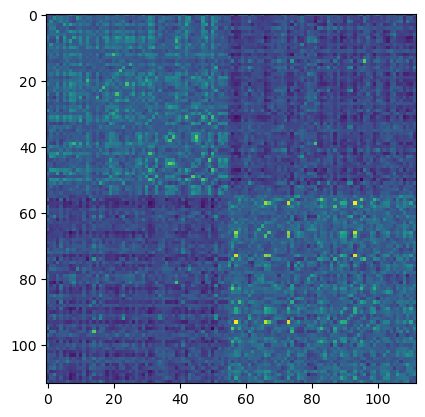

[0 1 2 0 2 2 0 2 1 0 1 1 2 3 1 3 3 0 2 3 2 0 1 1 3 2 0 2 3 3 0 3 3 1 3 2 2
 0 2 3 3 1 2 2 0 0 2 3 0 0 1 2 2 0 0 1 0 2 2 3 2 0 3 3 0 3 0 0 0 0 0 0 2 0
 0 2 1 1 2 3 0 2 3 1 0 0 2 2 3 1 0 3 2 2 2 3 3 1 1 0 0 2 2 0 0 3 0 0 3 1 2
 1]
[36 19 32 25]
SCORE -0.2118182793566581


/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


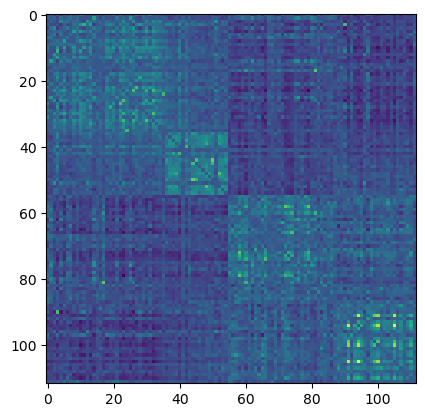

/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[1 2 4 0 5 5 0 5 3 0 3 2 4 7 2 6 6 0 5 6 5 0 2 2 6 5 0 4 7 7 1 7 7 2 6 5 4
 1 5 6 6 2 4 5 1 0 4 6 1 0 3 5 5 1 0 3 0 5 4 7 4 0 6 7 0 7 1 0 1 0 1 0 5 1
 0 5 3 2 4 6 1 4 6 2 0 0 4 5 6 2 1 6 5 4 4 7 7 3 2 1 0 4 5 0 1 7 0 0 6 3 4
 2]
[22 14 12  7 15 17 14 11]
SCORE -0.1917623125704782


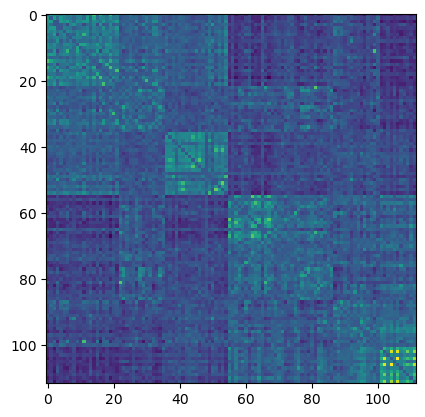

/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[ 2  4  8  0 10 10  0 10  7  0  6  4  8 15  4 12 13  0 11 13 11  1  4  4
 12 10  1  9 14 15  2 15 14  5 12 11  8  3 10 13 13  5  8 10  2  1  8 13
  2  1  6 11 11  2  1  6  0 11  9 14  8  1 13 14  1 14  2  0  3  0  3  0
 10  3  1 11  7  4  9 12  3  8 13  4  1  0  9 11 12  5  2 13 10  9  9 15
 15  6  5  2  1  8 11  1  3 15  1  0 12  6  8  4]
[10 12  8  6  8  4  5  2  9  6  8  9  6  8  5  6]
SCORE -0.18047552366019043


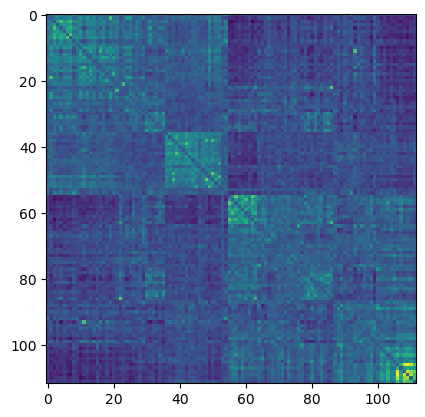

/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[ 5  8 17  0 20 20  0 20 14  0 13  8 17 31  9 25 26  1 23 27 23  2  9  9
 25 20  3 19 29 31  5 30 29 11 25 22 16  7 20 26 26 10 16 20  4  3 17 26
  4  3 12 22 22  5  3 13  1 23 19 29 17  2 27 29  2 28  4  0  6  0  6  1
 21  7  2 23 15  9 19 24  7 16 27  9  3  0 18 22 25 11  5 26 21 18 19 31
 31 13 10  5  3 16 23  2  7 31  2  0 25 12 17  9]
[7 3 6 6 3 5 2 4 2 6 2 2 2 3 1 1 4 5 2 4 6 2 4 5 1 5 5 3 1 4 1 5]
SCORE -0.19660747252077931


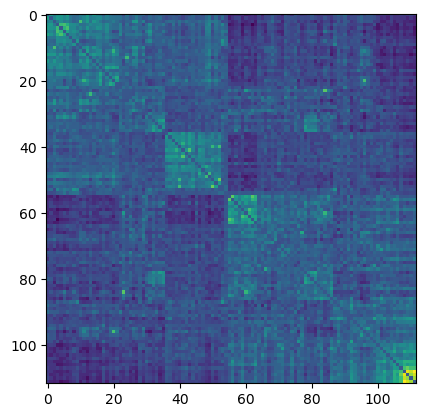

/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1
 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1
 0]
[55 57]
SCORE -1.0352212113493304


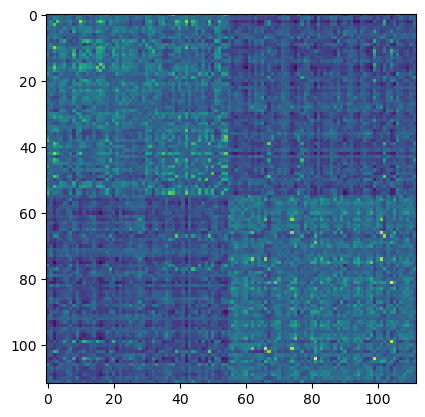

[3 0 2 1 2 2 1 2 0 1 0 0 3 3 0 3 2 1 3 3 3 1 2 0 0 0 2 2 3 3 0 2 3 0 0 3 3
 3 2 3 2 0 3 3 1 1 3 0 2 1 1 3 3 3 1 0 1 3 2 3 3 2 3 0 1 0 1 1 3 1 0 1 3 0
 1 3 1 0 1 0 1 3 3 0 1 1 3 3 3 0 1 2 2 0 2 3 0 2 2 1 1 3 1 1 3 3 1 0 2 1 2
 0]
[26 29 21 36]
SCORE -1.0109728853344984


/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


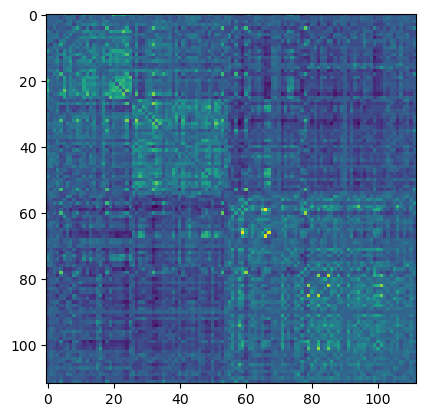

/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[1 0 5 2 5 5 2 4 0 2 0 0 6 6 0 7 5 3 7 7 7 2 5 0 1 0 4 5 6 6 1 4 6 0 1 7 7
 7 4 7 4 0 6 7 2 3 6 0 4 3 2 7 7 7 2 0 3 7 5 7 7 4 7 0 2 1 2 2 6 2 1 3 7 0
 3 6 3 0 3 0 3 7 6 0 2 2 7 7 6 0 2 5 5 0 5 6 0 4 5 2 4 7 3 2 7 6 2 0 5 2 5
 0]
[21  6 18 10  9 13 13 22]
SCORE -0.9779795332679873


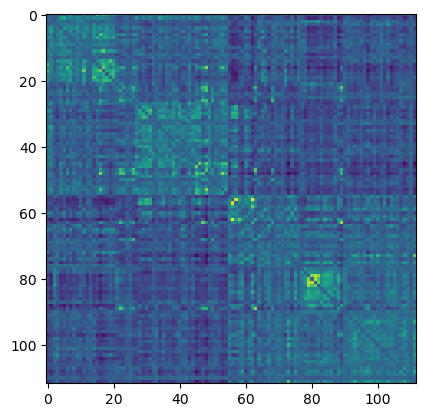

/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[ 6  1 10  5 10 11  5  8  1  5  1  1 13 13  1 15  8  6 15 14 14  4  9  1
  2  0  8 10 12 13  2  8 13  0  3 14 14 14  8 15  8  1  8 14  5  7 13  0
 10  7  4 14 14 15  4  1  7 14 11 15 14  8  8  0  4  2  5  4 13  5  2  7
 15  0  7 15  7  1  6  1  7 15 15  0  4  5 15 14 13  0  4 11  8  0 11 13
  0  9 10  4  4 14  7  4 14 13  5  0 10  4 10  1]
[10 11  4  1 11  8  3  8 10  2  7  4  1  9 13 10]
SCORE -0.9955475596734402


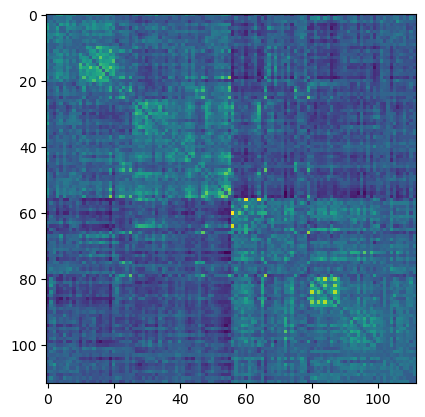

/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1
 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0
 1]
[61 51]
SCORE -1.1058889658904691


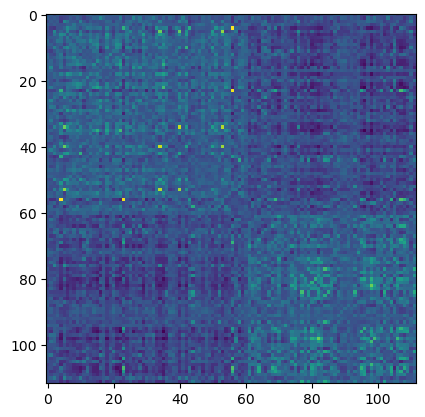

[0 3 0 2 0 0 2 1 3 3 3 3 1 1 3 0 1 2 0 0 0 2 3 0 3 0 1 0 1 1 3 1 1 2 3 0 0
 0 1 0 1 3 1 0 2 2 1 1 1 2 2 0 0 0 2 3 2 0 0 0 0 1 1 3 2 3 2 2 0 2 3 3 0 3
 2 0 2 3 0 3 3 1 3 3 2 2 0 0 1 3 2 0 1 0 1 1 3 1 1 2 2 0 3 2 0 1 2 3 1 2 1
 3]
[33 27 25 27]
SCORE -1.0774395159175532


/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


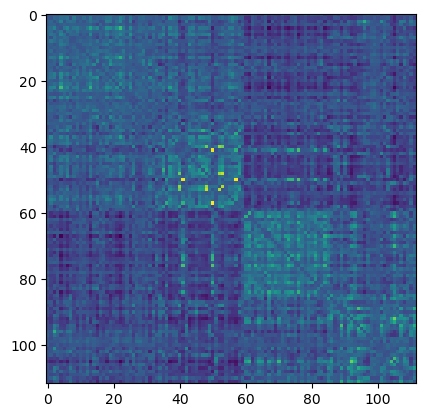

/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[1 6 0 4 1 1 5 3 7 7 6 6 2 2 1 1 3 5 1 1 0 4 6 1 6 1 3 1 2 2 6 3 2 5 6 1 1
 0 3 1 3 6 2 0 4 4 2 3 3 4 4 0 0 1 4 6 4 0 1 1 0 3 2 6 4 6 5 4 0 4 7 7 1 7
 4 0 4 6 1 7 6 3 7 6 5 5 0 0 2 7 4 1 2 1 3 2 7 3 3 5 4 1 6 4 0 2 5 7 3 4 2
 6]
[13 21 13 14 17  8 16 10]
SCORE -1.0559132135873939


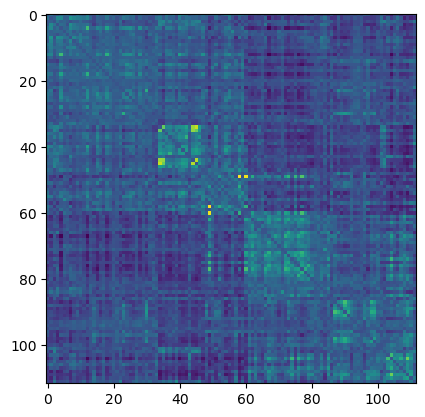

/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[ 2 13  1  8  3  3 11  6 15 15 13 13  4  4  2  2  7 10  3  3  1  8 13  2
 12  2  6  2  5  4 12  7  4 11 12  3  3  0  7  2  6 13  4  1  8  9  4  7
  7  8  9  0  0  2  9 13  8  1  2  2  0  6  4 12  8 13 11  8  1  8 14 15
  2 15  9  1  9 13  2 15 12  7 15 13 11 11  1  0  4 15  8  3  4  3  7  4
 15  6  7 11  9  3 12  8  0  4 11 15  6  9  4 13]
[ 6  7 12  9 12  1  6  8 10  7  1  7  6 10  1  9]
SCORE -1.0678333857960507


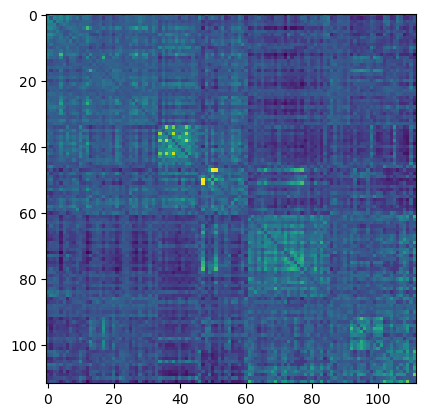

/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0
 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 1
 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0
 1]
[51 61]
SCORE -0.3563891834957251


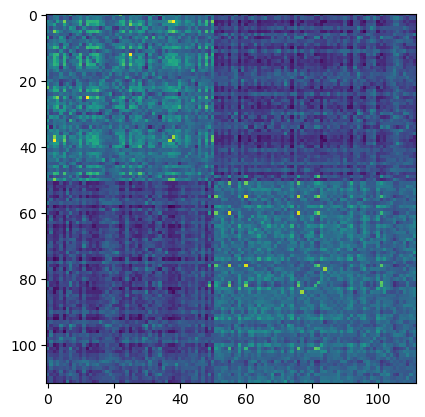

[2 3 1 1 3 3 1 1 1 3 0 3 0 1 3 3 3 2 3 1 0 3 3 3 2 3 0 3 2 0 2 1 0 0 2 3 1
 3 0 3 0 0 0 0 3 0 3 3 1 3 0 3 3 3 0 3 1 1 3 3 2 0 3 3 0 1 3 1 0 3 1 1 3 3
 0 0 1 3 2 0 3 1 3 3 0 3 3 0 1 3 3 2 3 0 3 1 3 0 0 3 0 3 3 3 2 1 1 3 0 0 0
 3]
[30 22 10 50]
SCORE -0.3054544366937266


/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


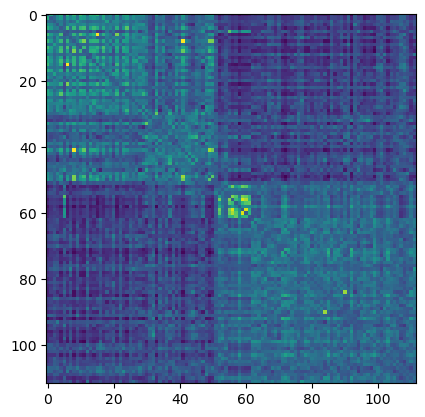

/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[4 6 3 2 7 7 2 3 3 7 0 6 0 3 6 7 6 4 6 3 0 7 6 6 4 6 0 7 5 0 5 3 0 1 5 6 3
 7 0 6 0 0 0 0 7 1 6 6 3 7 1 7 7 7 1 6 2 2 7 6 5 0 6 6 1 3 7 7 1 7 2 2 7 6
 1 0 2 6 4 1 7 3 6 6 1 7 7 1 2 6 7 4 6 0 6 3 6 1 0 7 1 6 6 7 5 2 2 6 0 0 0
 6]
[18 12 10 11  5  5 28 23]
SCORE -0.282901147853122


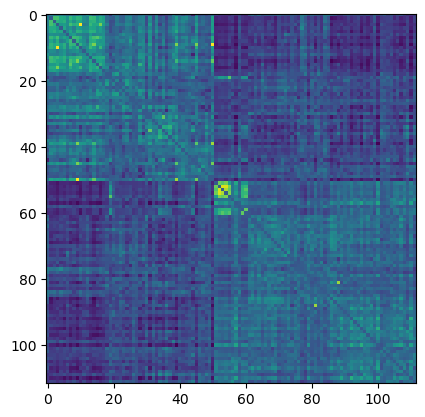

/tmp/ipykernel_4929/2553199531.py:72: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C)
/tmp/ipykernel_4929/2553199531.py:30: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lam, v = sp.linalg.eigh(A, eigvals=(0,0))


[ 9 13  7  4 14 14  4  7  6 15  1 12  0  6 13 14 12  8 12  7  1 15 12 13
  9 12  1 14 10  1 10  7  1  2 11 12  7 15  1 13  1  1  0  1 15  3 13 12
  6 15  3 15 15 14  3 12  5  4 14 13 10  1 12 13  3  7 15 15  3 15  4  5
 15 12  3  0  4 12  9  2 14  6 12 13  3 15 14  3  4 12 14  9 13  0 13  6
 12  2  1 14  3 12 12 14 10  5  4 13  0  1  0 12]
[ 6 12  3  9  7  3  5  6  1  4  4  1 17 11 11 12]
SCORE -0.30677076613561677


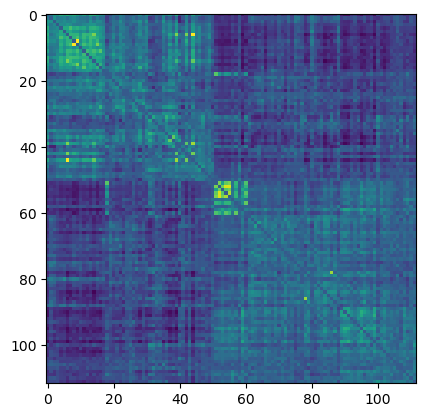

In [38]:
from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
# from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import scipy as sp

def get_cut(X):

    y = X
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    
    y2 = np.sum(y**2, axis=1, keepdims=True)/2

    y = np.hstack((y, y2, 0*y+1, y2 + 1))
    
    
    yX = np.matmul(y.T, X)

    
    minkowski = -np.ones((y.shape[1],1))
    minkowski[-1,0] = +1.0
 
    A = np.matmul(yX.T, minkowski*yX)
    
    Ao = np.expand_dims(A[:-1,-1],1)
    Aoo = A[-1,-1]
    A = A[:-1,:-1] - np.matmul(Ao, Ao.T)/Aoo
    
    
    lam, v = sp.linalg.eigh(A, eigvals=(0,0))
    v = np.vstack((v, -np.dot(Ao[:,0],v)/Aoo))
    
    
    c = np.matmul(X, v) > 0.0
    
    return c[:,0]


def otree_clusters(X, max_depth):

    sets = np.zeros((X.shape[0])).astype(int)

    for k in range(max_depth):
        new_sets = 0*sets
        
        for kk in range(np.max(sets)+1):
            b = sets==kk
            
            Xs = X[b, :] #x[features x components]
            
            
            c = get_cut(Xs)
            
            
            new_sets[b] = 2*sets[b] + c
        sets = new_sets
        
    return sets



def get_clusters(x, depth=3):  
    x[~np.isfinite(x)] = np.mean(x[np.isfinite(x)]) # x shape of (time_id=3830,stock_id= 112)

    x = x - np.nanmean(x, 0)
    x = x / (np.nanstd(x, 0)+1e-20)
    
    C = np.corrcoef(x.T)
    # plt.hist(C.flatten(),100)
    # plt.show()

    C = np.arctanh(C)
    # print(np.fill_diagonal(C, 0))
    # plt.hist(np.fill_diagonal(C, 0),100)
    # plt.show()

    a = np.arange(C.shape[0])
    C[a,a] = 0 #shape of (112,112)
        
    m = np.mean(C, 1, keepdims=True)
    C = C - (m + m.T) 
    C[a,a] = np.mean(C)

    pca = PCA(x.shape[1])
    pca.fit(x)
    c = pca.components_ * pca.singular_values_[:,np.newaxis]**.5 # shape of (112,112). eigenvector of ( x.T * x ) = 3830 * 112 x 112 * 112 * 3830 = 112 * 112
    c = c.T # features (stocks) x components

    c[:,0] = c[:,0]

    p = otree_clusters(c, depth)
    
    means = []    
    for k in range(np.max(p)+1):
        mn = np.mean(c[p==k, :], 0)
        means.append(mn)
    means= np.vstack(means)
    
    gm = GaussianMixture(means.shape[0], means_init=means, weights_init=np.ones(means.shape[0])/means.shape[0], covariance_type='full', 
                         precisions_init=np.repeat( np.eye(means.shape[1])[np.newaxis,:,:]/means.shape[1], repeats=means.shape[0], axis=0) )
                             
    p = gm.fit_predict(c)
    
    print(p)    
    _, cnts = np.unique( p, return_counts=True)
    print(cnts)

    score=0
    nc= np.max(p)+1
    for k in range(nc):
        Q =  C[p==k,:][:,p==k]
        score += np.mean(Q)/nc
    print('SCORE', score)
    
    
    k = np.argsort(p)
    
    plt.imshow( (C[k,:][:,k]) )
    plt.show()

    return p

def high_corr_set(x, q):  
    x[~np.isfinite(x)] = np.mean(x[np.isfinite(x)])

    x = x - np.nanmean(x, 0)
    x = x / np.nanstd(x, 0)

    C = np.corrcoef(x.T)
    c = np.median(C, 1)
    
    b = c > np.quantile(c,q)
    
    idxs =  np.arange(c.shape[0])[b]

    return idxs


rvol   = train_binned['root_volume']
vol    = train_binned['volume']
vol1   = train_binned['vol1']
lr1   = train_binned['lr1']
lsprd  = train_binned['log_spread']
r4liq3 = train_binned['liquidity3_4th_root']
liq2   = train_binned['liquidity2']

lr1 = np.mean(lr1,2)
vol1 = np.mean(vol1**2, 2)**.5
tvpl3 = np.log(np.mean( rvol, 2)**(1/2)/np.mean( (r4liq3[:,:, 0:]), 2)**(4/3))
rvol = np.log(np.mean(rvol**.5,2))
lsprd = (np.mean(lsprd,2))
vol1 = np.log(vol1)
vol = (np.mean(vol,2) )


lr1_clusters1 = get_clusters(lr1, depth=1) # lr1 shape of (time_id=3830,stock_id= 112)
lr1_clusters2 = get_clusters(lr1, depth=2)
lr1_clusters3 = get_clusters(lr1, depth=3)
lr1_clusters4 = get_clusters(lr1, depth=4)
lr1_clusters5 = get_clusters(lr1, depth=5)

lr1_hc = high_corr_set(lr1, .9)

tvpl3_clusters1 = get_clusters(tvpl3, depth=1)
tvpl3_clusters2 = get_clusters(tvpl3, depth=2)
tvpl3_clusters3 = get_clusters(tvpl3, depth=3)
tvpl3_clusters4 = get_clusters(tvpl3, depth=4)

vol1_clusters1 = get_clusters(vol1, depth=1)
vol1_clusters2 = get_clusters(vol1, depth=2)
vol1_clusters3 = get_clusters(vol1, depth=3)
vol1_clusters4 = get_clusters(vol1, depth=4)

vol1_hc = high_corr_set(vol1, .95)

vol_clusters1 = get_clusters(rvol, depth=1)
vol_clusters2 = get_clusters(rvol, depth=2)
vol_clusters3 = get_clusters(rvol, depth=3)
vol_clusters4 = get_clusters(rvol, depth=4)


del rvol, vol, vol1, lr1, lsprd, r4liq3, liq2



## Features

In [5]:

def nancorr(a, b):
    v = np.isfinite(a)*np.isfinite(b) > 0
    return np.corrcoef(a[v], b[v])[0,1]


def plot_by_sid(train, x, y):
    for u in np.unique(train['stock_id']):
        b = train['stock_id']==u
        plt.plot(x[b], y[b], '.', markersize=1)
    plt.show()
    



def cluster_agg(x, clusters, agg_fun):
    r = 0*x
    
    for k in range(np.max(clusters)+1):
        z = agg_fun(x[:,clusters==k,:], 1, keepdims=True)
        r[:,clusters==k,:] = np.repeat(z, repeats=int(np.sum(clusters==k)), axis=1)
    return r
    

def keys_to_array(d, features):
    
    sh = np.max( [d[f].shape[1] for f in features] )
    sq = np.max( [d[f].shape[0] for f in features] )
    
    for f in features:
        if d[f].shape[1]==1:
            d[f] = np.repeat(d[f], repeats=sh, axis=1)
        if d[f].shape[0]==1:
            d[f] = np.repeat(d[f], repeats=sq, axis=0)
        
    
    stack = [d[feature] for feature in features]
    
    X = np.dstack(stack)
    
    return X


def merge_features_to_df(fdict, df, features):
    sids = df['stock_id'].unique()

    T = fdict['time_ids'][:,:,0]
    S = fdict['stock_ids'][:,:,0]

    T = np.reshape(T, [T.shape[0]*T.shape[1]])
    S = np.reshape(S, [S.shape[0]*S.shape[1]])
    
    sh = np.max( [fdict[f].shape[1] for f in features] )
    sq = np.max( [fdict[f].shape[0] for f in features] )
    
    for f in features:
        if fdict[f].shape[1]==1:
            fdict[f] = np.repeat(fdict[f], repeats=sh, axis=1)
        if fdict[f].shape[0]==1:
            fdict[f] = np.repeat(fdict[f], repeats=sq, axis=0)
        
    
    reshaped_features = [np.reshape( fdict[feature], [fdict[feature].shape[0]*fdict[feature].shape[1]] )
                         for feature in features]


    
    dfz = pd.DataFrame(data=np.vstack([S,T] + reshaped_features  ).T, columns=['stock_id', 'time_id']+features)
    dfz['time_id' ] = dfz['time_id' ].astype(int)
    dfz['stock_id'] = dfz['stock_id'].astype(int)

    dfz = df.merge(dfz, on=['stock_id', 'time_id'], how='left')
    return dfz



def get_simple_features(binned_features, final_features, name, ffrom=0):
    v = binned_features[name]

    suffix = f'_from_{ffrom}'

    s  = np.mean(np.mean(v**2, (2), keepdims=True)**.5, 0, keepdims=True)

    final_features[name + suffix] =            np.log(             np.mean(v[:,:,ffrom:]**2, 2, keepdims=True)**0.5/final_features['vol1'])
    final_features[name+'stock_mean'+suffix] = np.log(s*np.median( np.mean( v[:,:,ffrom:]/s, 2, keepdims=True), 1, keepdims=True)/final_features['vol1'])

    

def get_cohesion_features(binned_features, final_features, ffrom=0):
    lr1 = binned_features['lr1']

    if ffrom > 0:
        suffix = f'_from_{ffrom}'
    else:
        suffix = ''
    
    s = np.mean( np.var(lr1, 0,keepdims=True), 2, keepdims=True)**0.5
    qs = lr1[:,:,ffrom:]/s

    final_features['tbin_var'               + suffix] = s*np.mean(  np.var( qs, 1, keepdims=True)         , 2, keepdims=True)**0.5/final_features['vol1']
    final_features['market_var'             + suffix] = s*np.mean( (np.mean(qs, 1, keepdims=True)     )**2, 2, keepdims=True)**0.5/final_features['vol1']
    final_features['deviations_from_market' + suffix] = s*np.mean( (np.mean(qs, 1, keepdims=True) - qs)**2, 2, keepdims=True)**0.5/final_features['vol1']
    
    



def get_misc_features(binned_features, final_features):
    vol    = binned_features['volume']
    vol1    = binned_features['vol1']

    rvol   = binned_features['root_volume']

    volcr  = binned_features['cube_root_volume']
    liq2   = binned_features['liquidity2']
    liq3   = binned_features['liquidity3']
    r4liq3 = binned_features['liquidity3_4th_root']
    lsprd  = binned_features['log_spread2']
    bsz  = binned_features['book_size']

    
    s  = np.nanmean( vol, (0,2), keepdims=True)
    sr = np.nanmean(rvol, (0,2), keepdims=True)
    l2 = np.nanmean(liq2, (0,2), keepdims=True)
    l3 = np.nanmean(liq3, (0,2), keepdims=True)

    v1 = np.nanmean(vol1**2, 2, keepdims=True)**.5
    
    final_features['soft_stock_mean_tvpl2'    ] = np.log( (s/l2*np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    final_features['soft_stock_mean_tvpl2_f10'] = np.log( (s/l2*np.nanmean( (vol[:,:,10:]/liq2[:,:,10:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    final_features['soft_stock_mean_tvpl2_f20'] = np.log( (s/l2*np.nanmean( (vol[:,:,20:]/liq2[:,:,20:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    
    final_features['soft_stock_mean_tvpl3'    ] = np.log( (sr/l3*np.nanmean( (rvol[:,:, 0:]/liq3[:,:, 0:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    final_features['soft_stock_mean_tvpl3_f10'] = np.log( (sr/l3*np.nanmean( (rvol[:,:,10:]/liq3[:,:,10:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    final_features['soft_stock_mean_tvpl3_f20'] = np.log( (sr/l3*np.nanmean( (rvol[:,:,20:]/liq3[:,:,20:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    
    final_features['soft_stock_mean_tvpl2_liqf'       ] = np.log( (s/l2*np.nanmean( (vol[:,:, 0:]/liq2[:,:,-1:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    final_features['soft_stock_mean_tvpl2_liqf_volf10'] = np.log( (s/l2*np.nanmean( (vol[:,:,10:]/liq2[:,:,-1:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    final_features['soft_stock_mean_tvpl2_liqf_volf20'] = np.log( (s/l2*np.nanmean( (vol[:,:,20:]/liq2[:,:,-1:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    
    final_features['soft_stock_mean_tvpl3_liqf'       ] = np.log( (sr/l3*np.nanmean( (rvol[:,:, 0:]/liq3[:,:,-1:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    final_features['soft_stock_mean_tvpl3_liqf_volf10'] = np.log( (sr/l3*np.nanmean( (rvol[:,:,10:]/liq3[:,:,-1:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    final_features['soft_stock_mean_tvpl3_liqf_volf20'] = np.log( (sr/l3*np.nanmean( (rvol[:,:,20:]/liq3[:,:,-1:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    
    

    tvpl3     = np.log( np.mean( rvol, 2, keepdims=True)**(1/2)/np.mean( (r4liq3[:,:, 0:]), (2), keepdims=True)**(4/3)/v1)
    tvpl3lf20 = np.log( np.mean( rvol, 2, keepdims=True)**(1/2)/np.mean( (r4liq3[:,:, 20:]), (2), keepdims=True)**(4/3)/v1)
    
    final_features['tvpl3_rmed2v1']     = np.log( np.median(tvpl3/v1,1, keepdims=True)    )
    final_features['tvpl3_rmed2v1lf20'] = np.log( np.median(tvpl3lf20/v1,1, keepdims=True))
    
    
    
    final_features['v1proj_25_15'] = np.log( np.nanmedian( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                         / np.mean(vol1[:,:,:15]**2,2,keepdims=True),1,keepdims=True)**.5 )
    
    
    final_features['v1proj_25_15_lr1_hc'] = np.log( np.nanmedian( np.mean(vol1[:,lr1_hc,25:]**2,2,keepdims=True)
                                                                / np.mean(vol1[:,lr1_hc,:15]**2,2,keepdims=True),1,keepdims=True)**.5 )
    
    final_features['v1proj_25_15_vol1_hc'] = np.log( np.nanmedian( np.mean(vol1[:,vol1_hc,25:]**2,2,keepdims=True)
                                                                 / np.mean(vol1[:,vol1_hc,:15]**2,2,keepdims=True),1,keepdims=True)**.5 ) 
    final_features['v1proj_25_lr1_hc']     = np.log( np.nanmedian( np.mean(vol1[:,lr1_hc,25:]**2,2,keepdims=True)
                                                             / np.mean(vol1[:,lr1_hc,:]**2,2,keepdims=True),1,keepdims=True)**.5 )
    final_features['v1proj_25_vol1_hc']    = np.log( np.nanmedian( np.mean(vol1[:,vol1_hc,25:]**2,2,keepdims=True)
                                                              / np.mean(vol1[:,vol1_hc,:]**2,2,keepdims=True),1,keepdims=True)**.5 )
    
    
    final_features['lsvol'] = np.log( np.nanmean(binned_features['lsvol'], 2, keepdims=True))    

    final_features['liqvol1'] = np.log( np.nanmean(binned_features['liqvol1'], 2, keepdims=True))    
    final_features['liqvol1_smean'] = np.log( np.nanmean(binned_features['liqvol1'], (1,2), keepdims=True))    

    final_features['liqvol1_smean_c3'] = np.log( cluster_agg(np.nanmean(binned_features['liqvol1'], 2, keepdims=True), lr1_clusters3,np.nanmedian))    

    
    
    final_features['liqvol2'] = np.log( np.nanmean(binned_features['liqvol2'], 2, keepdims=True))    
    final_features['liqvol3'] = np.log( np.nanmean(binned_features['liqvol3'], 2, keepdims=True))    

    
    final_features['liqvol1_15_15'] = np.log( np.nanmean(binned_features['liqvol1'][:,:,15:  ], 2, keepdims=True)
                                            /np.nanmean(binned_features['liqvol1'][:,:,  :15], 2, keepdims=True))    

    final_features['trade_count']      = np.log( np.nanmean(binned_features['trade_count']    , 2, keepdims=True))    
    final_features['root_trade_count'] = np.log( np.nanmean(binned_features['trade_count']**.5, 2, keepdims=True))    
    final_features['root_book_delta_count'] = np.log( np.nanmean(binned_features['book_delta_count']**.5, 2, keepdims=True))    

    final_features['root_trade_count_smean'] = np.log( np.nanmean(binned_features['trade_count']**.5, (1,2), keepdims=True))    

    final_features['root_trade_count_smean_c1'] = np.log( cluster_agg(np.nanmean(binned_features['trade_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters1,np.nanmean))
    final_features['root_trade_count_smean_c2'] = np.log( cluster_agg(np.nanmean(binned_features['trade_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters2,np.nanmean))
    final_features['root_trade_count_smean_c3'] = np.log( cluster_agg(np.nanmean(binned_features['trade_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters3,np.nanmean))    
    final_features['root_trade_count_var'] = np.log( np.nanvar(binned_features['trade_count']**.5, 2, keepdims=True))    

    
    final_features['root_book_delta_count_smean'] = np.log( np.nanmean(binned_features['book_delta_count']**.5, (1,2), keepdims=True))    

    final_features['root_book_delta_count_smean_c1'] = np.log( cluster_agg(np.nanmean(binned_features['book_delta_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters1,np.nanmean))
    final_features['root_book_delta_smean_c2'] = np.log( cluster_agg(np.nanmean(binned_features['book_delta_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters2,np.nanmean))
    final_features['root_book_delta_count_smean_c3'] = np.log( cluster_agg(np.nanmean(binned_features['book_delta_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters3,np.nanmean))    
    final_features['root_book_delta_count_var'] = np.log( np.nanvar(binned_features['book_delta_count']**.5, 2, keepdims=True))    

    
    
    final_features['trade_count_15_15']      = np.log( np.nanmean(binned_features['trade_count'][:,:,15:  ], 2, keepdims=True)/
                                                      np.nanmean(binned_features['trade_count'][:,:,  :15], 2, keepdims=True))    
    final_features['root_trade_count_15_15'] =  np.log( np.nanmean(binned_features['trade_count'][:,:,15:  ]**.5, 2, keepdims=True)/
                                                       np.nanmean(binned_features['trade_count'][:,:,  :15]**.5, 2, keepdims=True)) 
    
    
    final_features['v1proj_29_15'] = np.log( np.nanmedian( np.mean(vol1[:,:,29:  ]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,  :15]**2,2,keepdims=True),1,keepdims=True)**.5)
    final_features['v1proj_20']    = np.log( np.nanmedian( np.mean(vol1[:,:,20:  ]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,  :  ]**2,2,keepdims=True),1,keepdims=True)**.5 )   
    final_features['v1proj_25']    = np.log( np.nanmedian( np.mean(vol1[:,:,25:  ]**2,2,keepdims=True) 
                                                        / np.mean(vol1[:,:,  :  ]**2,2,keepdims=True),1,keepdims=True)**.5 )
    final_features['v1proj_29']    = np.log( np.nanmedian( np.mean(vol1[:,:,28:  ]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,  :  ]**2,2,keepdims=True),1,keepdims=True)**.5 )
    
    final_features['v1proj_29_q1'] = np.log( np.quantile( np.mean(vol1[:,:,28:]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,:  ]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )
    final_features['v1proj_29_q3'] = np.log( np.quantile( np.mean(vol1[:,:,28:]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,:  ]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )
    final_features['v1proj_25_q1'] = np.log( np.quantile( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,:  ]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )
    final_features['v1proj_25_q3'] = np.log( np.quantile( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,:  ]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 ) 
    
    final_features['v1proj_29_15_q1'] = np.log( np.quantile( np.mean(vol1[:,:,28:  ]**2,2,keepdims=True)
                                                           / np.mean(vol1[:,:,  :15]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )
    final_features['v1proj_29_15_q3'] = np.log( np.quantile( np.mean(vol1[:,:,28:  ]**2,2,keepdims=True)
                                                           / np.mean(vol1[:,:,  :15]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )
    final_features['v1proj_25_15_q1'] = np.log( np.quantile( np.mean(vol1[:,:,25:  ]**2,2,keepdims=True)
                                                           / np.mean(vol1[:,:,  :15]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )
    final_features['v1proj_25_15_q3'] = np.log( np.quantile( np.mean(vol1[:,:,25:  ]**2,2,keepdims=True)
                                                           / np.mean(vol1[:,:,  :15]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )
    
    
      
    
    
    
    
    final_features['v1proj_25_15_std'] = np.log( np.nanstd( np.log( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                               / np.mean(vol1[:,:,:15]**2,2,keepdims=True)),1,keepdims=True)**.5 )
    final_features['v1proj_29_15_std'] = np.log( np.nanstd( np.log( np.mean(vol1[:,:,29:]**2,2,keepdims=True)
                                                               / np.mean(vol1[:,:,:15]**2,2,keepdims=True)),1,keepdims=True)**.5 )
    
    final_features['v1proj_20_std'] = np.log( np.nanstd( np.log(np.mean(vol1[:,:,20:]**2,2,keepdims=True)
                                                            /np.mean(vol1[:,:,:  ]**2,2,keepdims=True))
                                                    ,1,keepdims=True) )
    final_features['v1proj_25_std'] = np.log( np.nanstd( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                            /np.mean(vol1[:,:,:  ]**2,2,keepdims=True))
                                                    ,1,keepdims=True) )
    final_features['v1proj_29_std'] = np.log( np.nanstd( np.log(np.mean(vol1[:,:,28:]**2,2,keepdims=True)
                                                            /np.mean(vol1[:,:,:  ]**2,2,keepdims=True))
                                                    ,1,keepdims=True) )
    
    
    final_features['v1proj_29_q3q1'] = np.log(np.quantile( np.log(np.mean(vol1[:,:,28:]**2,2,keepdims=True)
                                                            /np.mean(vol1[:,:,:  ]**2,2,keepdims=True))
                                                    ,0.75, axis=1,keepdims=True)
                                                -
                                                np.quantile( np.log(np.mean(vol1[:,:,28:]**2,2,keepdims=True)
                                                            /np.mean(vol1[:,:,:  ]**2,2,keepdims=True))
                                                    ,0.25, axis=1,keepdims=True))
    
    if vol1.shape[1]>100:
        final_features['v1proj_25_c1'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        lr1_clusters1, np.median)**0.5 )  
        final_features['v1proj_25_c2'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        lr1_clusters2, np.median)**0.5 )
        final_features['v1proj_25_c3'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        lr1_clusters3, np.median)**0.5 )
        final_features['v1proj_25_c4'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        lr1_clusters4, np.median)**0.5 )
        final_features['v1proj_25_c5'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        lr1_clusters5, np.median)**0.5 )
        
  

        final_features['soft_stock_mean_tvpl2_c1'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters1, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_c2'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters2, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_c3'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters3, np.mean)**8**.5/v1)
        
        final_features['soft_stock_mean_tvpl2_10_c1'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 10:]/liq2[:,:,10:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters1, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_10_c2'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 10:]/liq2[:,:,10:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters2, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_10_c3'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 10:]/liq2[:,:,10:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters3, np.mean)**8**.5/v1)
        
        final_features['soft_stock_mean_tvpl2_20_c1'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 20:]/liq2[:,:,20:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters1, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_20_c2'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 20:]/liq2[:,:,20:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters2, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_20_c3'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 20:]/liq2[:,:,20:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters3, np.mean)**8**.5/v1)

        
        final_features['v1proj_25_c1_std'] = np.log( cluster_agg( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True)),
                                                        lr1_clusters1, np.nanstd)**0.5  )  
        final_features['v1proj_25_c2_std'] = np.log( cluster_agg( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True)),
                                                        lr1_clusters2, np.nanstd)**0.5 )
        final_features['v1proj_25_c3_std'] = np.log( cluster_agg( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True)),
                                                        lr1_clusters3, np.nanstd)**0.5 )
        final_features['v1proj_25_c4_std'] = np.log( cluster_agg( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True)),
                                                        lr1_clusters4, np.nanstd)**0.5 )
        final_features['v1proj_25_c5_std'] = np.log( cluster_agg( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True)),
                                                        lr1_clusters5, np.nanstd)**0.5 )
        
        
        final_features['v1proj_25_vc1'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol1_clusters1, np.median)**0.5  )  
        final_features['v1proj_25_vc2'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol1_clusters2, np.median)**0.5 )
        final_features['v1proj_25_vc3'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol1_clusters3, np.median)**0.5 )
    
        final_features['v1proj_25_vc4'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol1_clusters4, np.median)**0.5 )

        
        final_features['v1proj_25_tc1'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        tvpl3_clusters1, np.median)**0.5  )  
        final_features['v1proj_25_tc2'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        tvpl3_clusters2, np.median)**0.5 )
        final_features['v1proj_25_tc3'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        tvpl3_clusters3, np.median)**0.5 )
        final_features['v1proj_25_tc4'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        tvpl3_clusters4, np.median)**0.5 )

        final_features['v1proj_25_vvc1'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol_clusters1, np.median)**0.5  )  
        final_features['v1proj_25_vvc2'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol_clusters2, np.median)**0.5 )
        final_features['v1proj_25_vvc3'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol_clusters3, np.median)**0.5 )

        
        
        final_features['v1spprojt15f25_c1'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           lr1_clusters1, np.median) )
        final_features['v1spprojt15f25_c2'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           lr1_clusters2, np.median) )
        final_features['v1spprojt15f25_c3'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           lr1_clusters3, np.median) )
        final_features['v1spprojt15f25_c4'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           lr1_clusters4, np.median) )

        final_features['v1spprojt15f25_vc1'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           vol1_clusters1, np.median) )
        final_features['v1spprojt15f25_vc2'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           vol1_clusters2, np.median) )
        final_features['v1spprojt15f25_vc3'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           vol1_clusters3, np.median) )  
    
    
    final_features['tvpl3_rmed2v1'] = np.log( np.median( 
                                        np.mean( rvol           , 2, keepdims=True)**(1/2)/
                                        np.mean( r4liq3[:,:, 0:], 2, keepdims=True)**(4/3)/v1,
                                            1, keepdims=True) )
    final_features['tvpl3_rmed2v1_29'] = np.log( np.median( 
                                                np.mean( rvol           , 2, keepdims=True)**(1/2)/
                                                np.mean( r4liq3[:,:, 29:], 2, keepdims=True)**(4/3)/v1,
                                            1, keepdims=True) )

    
    final_features['tvpl2_rmed2v1']     = np.log( np.median( ( np.mean( vol              , 2, keepdims=True)**.5
                                                    / np.mean( liq2[:,:, 0:]**.5, 2, keepdims=True))/v1, 1, keepdims=True))
    final_features['tvpl2_rmed2v1lf25'] = np.log( np.median(( np.mean( vol, 2, keepdims=True)**.5
                                                    / np.mean( (liq2[:,:, 25:])**.5, (2), keepdims=True))/v1, 1, keepdims=True))
    final_features['tvpl2_rmed2v1lf29'] = np.log( np.median(( np.mean( vol, 2, keepdims=True)**.5
                                                    / np.mean( (liq2[:,:, 29:])**.5, (2), keepdims=True))/v1, 1, keepdims=True))
    
    
    
    ###
    final_features['tvpl2']        = np.log( np.mean( vol, 2, keepdims=True)**.5/np.mean( (liq2)**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_liqf10'] = np.log( np.mean( vol, 2, keepdims=True)**.5/np.mean( (liq2[:,:,10:])**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_liqf20'] = np.log( np.mean( vol, 2, keepdims=True)**.5/np.mean( (liq2[:,:,20:])**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_liqf29'] = np.log( np.mean( vol, 2, keepdims=True)**.5/np.mean( (liq2[:,:,29:])**.5, (2), keepdims=True)/v1)

    final_features['tvpl2_smean_vol'       ] = np.log( np.mean( vol, (0,2), keepdims=True)**.5/np.mean( (liq2[:,:, 0:])**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_smean_vol_liqf10'] = np.log( np.mean( vol, (0,2), keepdims=True)**.5/np.mean( (liq2[:,:,10:])**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_smean_vol_liqf20'] = np.log( np.mean( vol, (0,2), keepdims=True)**.5/np.mean( (liq2[:,:,20:])**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_smean_vol_liqf29'] = np.log( np.mean( vol, (0,2), keepdims=True)**.5/np.mean( (liq2[:,:,29:])**.5, (2), keepdims=True)/v1)
    
    
    final_features['tvpl3'       ] = np.log(np.mean( rvol, 2, keepdims=True)/np.mean( (r4liq3[:,:, 0:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_liqf10'] = np.log(np.mean( rvol, 2, keepdims=True)/np.mean( (r4liq3[:,:,10:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_liqf20'] = np.log(np.mean( rvol, 2, keepdims=True)/np.mean( (r4liq3[:,:,20:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_liqf29'] = np.log(np.mean( rvol, 2, keepdims=True)/np.mean( (r4liq3[:,:,29:]), (2), keepdims=True)**(4/3)/v1)

    final_features['tvpl3_smean_vol'       ] = np.log(np.mean( rvol, (0,2), keepdims=True)**.5/np.mean( (r4liq3[:,:, 0:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_smean_vol_liqf10'] = np.log(np.mean( rvol, (0,2), keepdims=True)**.5/np.mean( (r4liq3[:,:,10:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_smean_vol_liqf20'] = np.log(np.mean( rvol, (0,2), keepdims=True)**.5/np.mean( (r4liq3[:,:,20:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_smean_vol_liqf29'] = np.log(np.mean( rvol, (0,2), keepdims=True)**.5/np.mean( (r4liq3[:,:,29:]), (2), keepdims=True)**(4/3)/v1)


    
    
    
    final_features['v1liq2projt5'] = np.log( ( np.mean( liq2[:,:,  : 5]**(1/8), 2, keepdims=True)**8
                                            / np.mean( liq2[:,:,28:  ]       , 2, keepdims=True) )**(1/2) )
    final_features['v1liq3projt5'] = np.log( ( np.mean( liq3[:,:,  : 5]**(1/8), 2, keepdims=True)**8
                                            / np.mean( liq3[:,:,28:  ]       , 2, keepdims=True) )**(1/3) )
    
    final_features['v1liq2projt10'] = np.log( ( np.mean( liq2[:,:,  :10]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liq2[:,:,28:  ]       , 2, keepdims=True) )**(1/2) )
    final_features['v1liq3projt10'] = np.log( ( np.mean( liq3[:,:,  :10]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liq3[:,:,28:  ]       , 2, keepdims=True) )**(1/3) )
    
    final_features['v1liq2projt20'] = np.log( ( np.mean( liq2[:,:,  :20]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liq2[:,:,28:  ]       , 2, keepdims=True) )**(1/2) )
    final_features['v1liq3projt20'] = np.log( ( np.mean( liq3[:,:,  :20]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liq3[:,:,28:  ]       , 2, keepdims=True) )**(1/3) )
    
    final_features['liqt10rf29'] = np.log( np.mean( liq2[:,:,:10]**.5, (2), keepdims=True)**2 / liq2[:,:,29:] )
    final_features['liqt20rf29'] = np.log( np.mean( liq2[:,:,:20]**.5, (2), keepdims=True)**2 / liq2[:,:,29:] )
    
    
    final_features['v1liq2sprojt10f25'] = np.log( np.median(
                          np.mean(liq2[:,:,  :10]**.125, (2),keepdims=True)**8/
                          np.mean(liq2[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/2) )
    final_features['v1liq2sprojt5f25'] = np.log( np.median(
                          np.mean(liq2[:,:,  : 5]**.125, (2),keepdims=True)**8/
                          np.mean(liq2[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/2) )
    final_features['v1liq3sprojt15f25'] = np.log( np.median(
                          np.mean(liq3[:,:,  :15]**.125, (2),keepdims=True)**8/
                          np.mean(liq3[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/3) )
    final_features['v1liq3sprojt5f25'] = np.log( np.median(
                          np.mean(liq3[:,:,  : 5]**.125, (2),keepdims=True)**8/
                          np.mean(liq3[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/3) )
    
    final_features['v1liq3projt15f25'] = np.log( (
                          np.mean(liq3[:,:,  :15]**.125, (2),keepdims=True)**8/
                          np.mean(liq3[:,:,25:  ]**.125, (2),keepdims=True)**8
                           )**(1/3) )
    
    final_features['v1liq3sprojt10f25'] = np.log( np.median(
                          np.mean(liq3[:,:,  :  ]**.125, (2),keepdims=True)**8/
                          np.mean(liq3[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/3) )
    
    final_features['v1spprojt10f29'] = np.median(
                          - np.mean(lsprd[:,:,  :  ], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:  ], (2),keepdims=True)
                                    , 1, keepdims=True)
    final_features['v1spprojt15f25'] = np.median(
                          - np.mean(lsprd[:,:,  :15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:  ], (2),keepdims=True)
                           , 1, keepdims=True)
    
    final_features['v1spprojt15f29'] = np.median(
                          - np.mean(lsprd[:,:,  :15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:  ], (2),keepdims=True)
                                    , 1, keepdims=True)

    final_features['v1spprojt15f29_q1'] = np.quantile(
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:], (2),keepdims=True)
                                    ,0.25, 1, keepdims=True)
    final_features['v1spprojt15f29_q3'] = np.quantile(
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:], (2),keepdims=True)
                                    ,0.75, 1, keepdims=True)
    
    final_features['v1spprojt15f25_q1'] = np.quantile(
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True)
                                    ,0.25, 1, keepdims=True)
    final_features['v1spprojt15f25_q3'] = np.quantile(
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True)
                                    ,0.75, 1, keepdims=True)
    
    
    final_features['v1spprojtf29_q1'] = np.quantile(
                          - np.mean(lsprd[:,:,:], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:], (2),keepdims=True)
                                    ,0.25, 1, keepdims=True)
    final_features['v1spprojtf29_q3'] = np.quantile(
                          - np.mean(lsprd[:,:,:], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:], (2),keepdims=True)
                                    ,0.75, 1, keepdims=True)
    
    
    final_features['v1spprojtf25_q1'] = np.quantile(
                          - np.mean(lsprd[:,:,:], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True)
                                    ,0.25, 1, keepdims=True)
    final_features['v1spprojtf25_q3'] = np.quantile(
                          - np.mean(lsprd[:,:,:], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True)
                                    ,0.75, 1, keepdims=True)
    
    
def read_targets_from_df(df, s, t):
    t = list(t)
    s = list(s)
    
    
    Z = np.zeros((len(t), len(s)))
    
    dft = np.array(df['time_id'])
    dfs = np.array(df['stock_id'])
    dfr = np.array(df['target'])
    
    
    for k in range(df.shape[0]):
        Z[t.index(dft[k]), s.index(dfs[k])] = dfr[k]
    return Z
    
    

def get_features(binned_features):
    final_features = {}

    final_features[ 'time_ids'] = (1*binned_features['time_ids'][:,np.newaxis] + 0*binned_features['stock_ids'][np.newaxis,:])[:,:,np.newaxis]
    final_features['stock_ids'] = (0*binned_features['time_ids'][:,np.newaxis] + 1*binned_features['stock_ids'][np.newaxis,:])[:,:,np.newaxis]

    final_features['vol1'] = np.mean(binned_features['vol1']**2, 2, keepdims=True)**0.5
    final_features['cvol1'] = np.log(np.mean(binned_features['cvol1']**2, 2, keepdims=True)**0.5/final_features['vol1'])
    final_features['evol1'] = np.log(np.mean(binned_features['evol1']**2, 2, keepdims=True)**0.5/final_features['vol1'])
    final_features['e2vol1'] = np.log(np.mean(binned_features['e2vol1']**2, 2, keepdims=True)**0.5/final_features['vol1'])

    final_features['lvol1'] = np.log(np.mean(binned_features['lvol1']**2, 2, keepdims=True)**0.5)
    final_features['svol1'] = np.log(np.mean(binned_features['svol1']**2, 2, keepdims=True)**0.5)

    
    final_features['cvol1_15_15'] = np.log( np.mean(binned_features['cvol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['cvol1'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    
    final_features['lvol1_15_15'] = np.log( np.mean(binned_features['lvol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['lvol1'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    final_features['svol1_15_15'] = np.log( np.mean(binned_features['svol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['svol1'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    
    final_features['evol1_15_15'] = np.log( np.mean(binned_features['evol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['evol1'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    final_features['e2vol1_15_15'] = np.log( np.mean(binned_features['e2vol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['e2vol1'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    final_features['vol2e_15_15'] = np.log( np.mean(binned_features['vol2e'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['vol2e'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    
    
    final_features['vol2e_15_15s'] = np.log(np.median( np.mean(binned_features['vol2e'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                                    / np.mean(binned_features['vol2e'][:,:,  :15]**2, 2, keepdims=True)**0.5,1,keepdims=True))
    final_features['cvol1_15_15s'] = np.log(np.median( np.mean(binned_features['cvol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                                    / np.mean(binned_features['cvol1'][:,:,  :15]**2, 2, keepdims=True)**0.5,1,keepdims=True))
    final_features['svol1_15_15s'] = np.log(np.median( np.mean(binned_features['svol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                                    / np.mean(binned_features['svol1'][:,:,  :15]**2, 2, keepdims=True)**0.5,1,keepdims=True))
    final_features['vol2e'] = np.log(np.mean(binned_features['vol2e']**2, 2, keepdims=True)**0.5/final_features['vol1'])
    
    final_features['volq0_lm'] = np.log(np.mean(binned_features['volq0_lm']**2, 2, keepdims=True)**0.5/final_features['vol1'] )
    final_features['volq0_lp'] = np.log(np.mean(binned_features['volq0_lp']**2, 2, keepdims=True)**0.5/final_features['vol1'] )
    final_features['volq0_dt'] = final_features['volq0_lp'] - final_features['volq0_lm']

    get_cohesion_features(binned_features, final_features)
    get_cohesion_features(binned_features, final_features, ffrom=10)
    get_cohesion_features(binned_features, final_features, ffrom=20)
    
    get_misc_features(binned_features, final_features)

    get_simple_features(binned_features, final_features, 'vol1', ffrom=0)
    get_simple_features(binned_features, final_features, 'vol1', ffrom=10)
    get_simple_features(binned_features, final_features, 'vol1', ffrom=20)
    get_simple_features(binned_features, final_features, 'vol1', ffrom=25)
    
    get_simple_features(binned_features, final_features, 'qvol1', ffrom=0)
    get_simple_features(binned_features, final_features, 'qvol1', ffrom=10)
    get_simple_features(binned_features, final_features, 'qvol1', ffrom=20)
    get_simple_features(binned_features, final_features, 'qvol1', ffrom=25)
    
    
    final_features['vol1_mean'] = np.log(final_features['vol1']/np.nanmean(final_features['vol1'], 0, keepdims=True))
    
    final_features['mean_half_delta'] = np.nanstd( np.log( np.mean( binned_features['vol1'][:,:,15:  ]**2, 2, keepdims=True)
                                                         / np.mean( binned_features['vol1'][:,:,  :15]**2, 2, keepdims=True) )
                                               , 0, keepdims=True)  
    final_features['mean_half_delta_lsprd'] = np.log(np.nanstd( (  binned_features['log_spread'][:,:,-1: ]
                                                         -  binned_features['log_spread'][:,:,  :1] )
                                               , 0, keepdims=True) )
    final_features['vol1'] = np.log(final_features['vol1'])
    
    return final_features


train_feat = get_features(train_binned)
train_feat['target'] = read_targets_from_df(train, train_binned['stock_ids'], train_binned['time_ids'])

time_features = ['liquidity2', 'vol1', 'lr1']





del train_binned
gc.collect()


train_df = merge_features_to_df(train_feat, train, [f for f in list(train_feat.keys()) if ('time_id' not in f)])
 
train_df['lr1_clusters3'] = train_df['stock_id'].apply(lambda x: lr1_clusters3[int(np.argmax(np.array(train_feat['stock_ids'][0,:,0])==x))  ])
train_df['lr1_clusters2'] = train_df['stock_id'].apply(lambda x: lr1_clusters2[int(np.argmax(np.array(train_feat['stock_ids'][0,:,0])==x))  ])

del train_df['target_x']
train_df['target'] = train_df['target_y']
del train_df['target_y']



if IS_GOOD_TEST:
    test_feat = get_features(test_binned)
    
    del test_binned
    gc.collect()
    
    test_df = merge_features_to_df(test_feat, test, [f for f in list(test_feat.keys()) if ('time_id' not in f)])
    
    test_df['lr1_clusters3'] = test_df['stock_id'].apply(lambda x: lr1_clusters3[int(np.argmax(np.array(test_feat['stock_ids'][0,:,0])==x))  ])
    test_df['lr1_clusters2'] = test_df['stock_id'].apply(lambda x: lr1_clusters2[int(np.argmax(np.array(test_feat['stock_ids'][0,:,0])==x))  ])

else:
    test_feat = {}
    test_df = train_df.copy(deep=True)

    
    for key in train_feat.keys():
        if key != 'target':
            test_feat[key] = train_feat[key].copy()

            
    dummy_test = train.copy(deep=True)
    
features = [f for f in list(train_feat.keys()) if ('time_id' not in f and 'stock_id' not in f and 'target' not in f)]
features.remove('vol1_from_0')




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:594: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:596: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:603: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:603: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:603: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:607: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:607: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:612: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipy

## LGBM Model

CLUSTER: 0 0.3214239086848265
model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.21456
[500]	valid_0's RMSPE: 0.21115
[750]	valid_0's RMSPE: 0.21036
[1000]	valid_0's RMSPE: 0.21005
[1250]	valid_0's RMSPE: 0.2099
[1500]	valid_0's RMSPE: 0.20979
[1750]	valid_0's RMSPE: 0.20972
[2000]	valid_0's RMSPE: 0.20979
[2250]	valid_0's RMSPE: 0.20979
Early stopping, best iteration is:
[1865]	valid_0's RMSPE: 0.2097
SCORE: 0.20970394619124133
0.44403416343718066
0.5876196351293768
0.9183793996207297
0.9355411708798613


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.21715
[500]	valid_0's RMSPE: 0.21297
[750]	valid_0's RMSPE: 0.21179
[1000]	valid_0's RMSPE: 0.21115
[1250]	valid_0's RMSPE: 0.21082
[1500]	valid_0's RMSPE: 0.21072
[1750]	valid_0's RMSPE: 0.2106
[2000]	valid_0's RMSPE: 0.21054
[2250]	valid_0's RMSPE: 0.21049
[2500]	valid_0's RMSPE: 0.21054
Early stopping, best iteration is:
[2224]	valid_0's RMSPE: 0.21049
SCORE: 0.2104946685107734
0.5306310829456954
0.5813062434384836
0.9060309173714
0.9337182587580394


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22062
[500]	valid_0's RMSPE: 0.21625
[750]	valid_0's RMSPE: 0.21513
[1000]	valid_0's RMSPE: 0.21482
[1250]	valid_0's RMSPE: 0.21458
[1500]	valid_0's RMSPE: 0.21442
[1750]	valid_0's RMSPE: 0.21436
[2000]	valid_0's RMSPE: 0.21443
[2250]	valid_0's RMSPE: 0.21446
Early stopping, best iteration is:
[1772]	valid_0's RMSPE: 0.21433
SCORE: 0.2143342640202602
0.5539995519027899
0.5959885316557341
0.9164889275417732
0.9335966423157859


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22245
[500]	valid_0's RMSPE: 0.21889
[750]	valid_0's RMSPE: 0.21783
[1000]	valid_0's RMSPE: 0.21741
[1250]	valid_0's RMSPE: 0.21729
[1500]	valid_0's RMSPE: 0.21726
[1750]	valid_0's RMSPE: 0.21727
Early stopping, best iteration is:
[1344]	valid_0's RMSPE: 0.21719
SCORE: 0.21719067363836497
0.5071785524732616
0.569229613610071
0.9077718147173877
0.930882903436078


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

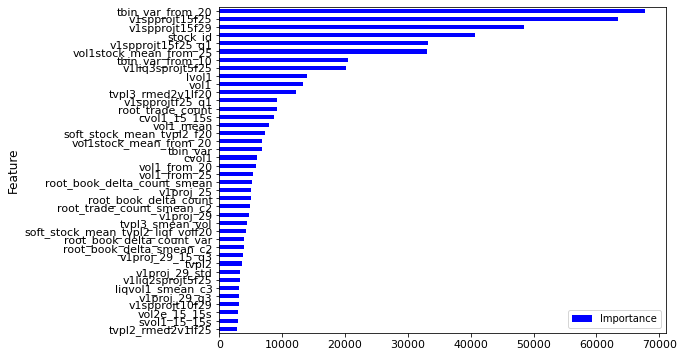

CLUSTER: 1 0.16965393115925134
model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.19797
[500]	valid_0's RMSPE: 0.19352
[750]	valid_0's RMSPE: 0.19246
[1000]	valid_0's RMSPE: 0.19219
[1250]	valid_0's RMSPE: 0.19207
[1500]	valid_0's RMSPE: 0.19213
Early stopping, best iteration is:
[1209]	valid_0's RMSPE: 0.19203
SCORE: 0.19203378151737413
0.5340155923935558
0.6108695780172488
0.9242915551384608
0.9336458126550334


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.20232
[500]	valid_0's RMSPE: 0.19805
[750]	valid_0's RMSPE: 0.19674
[1000]	valid_0's RMSPE: 0.1962
[1250]	valid_0's RMSPE: 0.1959
[1500]	valid_0's RMSPE: 0.19585
[1750]	valid_0's RMSPE: 0.19575
[2000]	valid_0's RMSPE: 0.19574
[2250]	valid_0's RMSPE: 0.19576
Early stopping, best iteration is:
[1974]	valid_0's RMSPE: 0.19572
SCORE: 0.1957245622388994
0.5399142383187392
0.5894636178054973
0.9196417522956838
0.9303730578727497


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.20389
[500]	valid_0's RMSPE: 0.19956
[750]	valid_0's RMSPE: 0.19833
[1000]	valid_0's RMSPE: 0.19799
[1250]	valid_0's RMSPE: 0.19771
[1500]	valid_0's RMSPE: 0.19751
[1750]	valid_0's RMSPE: 0.19754
[2000]	valid_0's RMSPE: 0.19758
Early stopping, best iteration is:
[1660]	valid_0's RMSPE: 0.19749
SCORE: 0.197489854279099
0.5541241200954722
0.6021342503954802
0.923826589825891
0.9316465416844711


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.2027
[500]	valid_0's RMSPE: 0.19855
[750]	valid_0's RMSPE: 0.19759
[1000]	valid_0's RMSPE: 0.19721
[1250]	valid_0's RMSPE: 0.19726
[1500]	valid_0's RMSPE: 0.19717
[1750]	valid_0's RMSPE: 0.19718
[2000]	valid_0's RMSPE: 0.19731
Early stopping, best iteration is:
[1550]	valid_0's RMSPE: 0.1971
SCORE: 0.19710404318720043
0.47350706624337513
0.5836227909678626
0.9206157981067773
0.9291631934968465


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

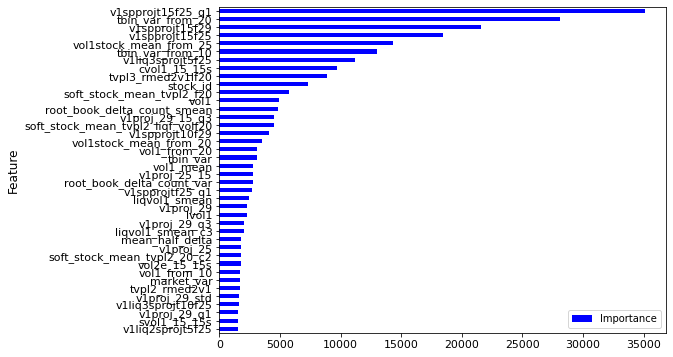

CLUSTER: 2 0.285695634739306
model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22055
[500]	valid_0's RMSPE: 0.21554
[750]	valid_0's RMSPE: 0.21433
[1000]	valid_0's RMSPE: 0.21396
[1250]	valid_0's RMSPE: 0.21367
[1500]	valid_0's RMSPE: 0.21371
[1750]	valid_0's RMSPE: 0.21376
Early stopping, best iteration is:
[1263]	valid_0's RMSPE: 0.21365
SCORE: 0.21365432799408232
0.5692562128927467
0.6397499258287227
0.9283124852014664
0.9338234799739691


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.2188
[500]	valid_0's RMSPE: 0.2139
[750]	valid_0's RMSPE: 0.21262
[1000]	valid_0's RMSPE: 0.2121
[1250]	valid_0's RMSPE: 0.21179
[1500]	valid_0's RMSPE: 0.21168
[1750]	valid_0's RMSPE: 0.21169
Early stopping, best iteration is:
[1425]	valid_0's RMSPE: 0.21164
SCORE: 0.21164341787479926
0.5404507465736029
0.6236673462639643
0.9225480329462372
0.9329745437889799


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22131
[500]	valid_0's RMSPE: 0.2167
[750]	valid_0's RMSPE: 0.21576
[1000]	valid_0's RMSPE: 0.21541
[1250]	valid_0's RMSPE: 0.21527
[1500]	valid_0's RMSPE: 0.21531
[1750]	valid_0's RMSPE: 0.21535
Early stopping, best iteration is:
[1322]	valid_0's RMSPE: 0.21523
SCORE: 0.21523126168617465
0.5234668885924157
0.6369714815496018
0.9184839664689289
0.9342889490237264


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.21942
[500]	valid_0's RMSPE: 0.21576
[750]	valid_0's RMSPE: 0.2148
[1000]	valid_0's RMSPE: 0.21454
[1250]	valid_0's RMSPE: 0.21449
[1500]	valid_0's RMSPE: 0.21458
Early stopping, best iteration is:
[1112]	valid_0's RMSPE: 0.21445
SCORE: 0.2144532209204366
0.5420843761164351
0.6114937953814574
0.9248171777151218
0.9309743537881026


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

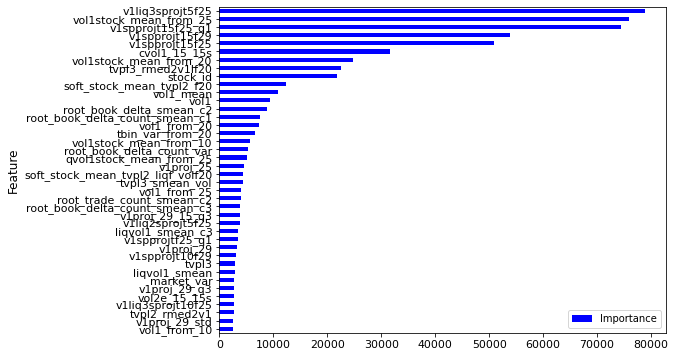

CLUSTER: 3 0.22322652541661617
model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.2289
[500]	valid_0's RMSPE: 0.22462
[750]	valid_0's RMSPE: 0.22445
[1000]	valid_0's RMSPE: 0.22566
Early stopping, best iteration is:
[578]	valid_0's RMSPE: 0.2243
SCORE: 0.22430428543334455
0.44786073316010727
0.5648213462412943
0.9290935790111334
0.9338709261695601


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.23641
[500]	valid_0's RMSPE: 0.23122
[750]	valid_0's RMSPE: 0.22972
[1000]	valid_0's RMSPE: 0.2299
[1250]	valid_0's RMSPE: 0.22979
Early stopping, best iteration is:
[838]	valid_0's RMSPE: 0.22951
SCORE: 0.22950685888020453
0.3717572515758606
0.5433548469288275
0.9214862327242571
0.9299989606139678


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22944
[500]	valid_0's RMSPE: 0.22488
[750]	valid_0's RMSPE: 0.22354
[1000]	valid_0's RMSPE: 0.2232
[1250]	valid_0's RMSPE: 0.22342
Early stopping, best iteration is:
[931]	valid_0's RMSPE: 0.22316
SCORE: 0.22316344720936193
0.5064547330418171
0.5810304366391547
0.9325059864015575
0.9370277338538368


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

model


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.25834
[500]	valid_0's RMSPE: 0.25331
[750]	valid_0's RMSPE: 0.25389
Early stopping, best iteration is:
[433]	valid_0's RMSPE: 0.25297
SCORE: 0.2529709570925633
0.40894350976745275
0.5307410454833649
0.9241595629304185
0.9299320763936917


/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

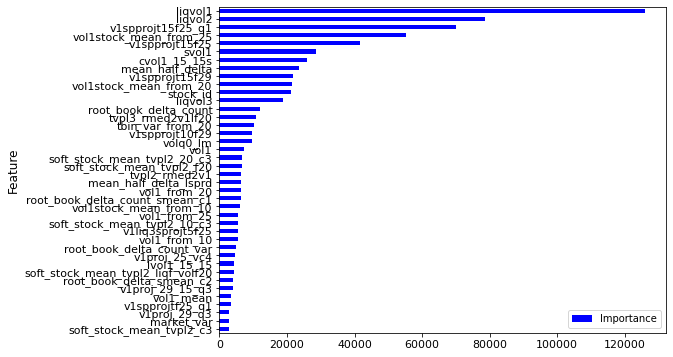

FULL SCORE: 0.21498227692889307


In [6]:
from sklearn.model_selection import KFold


model_name = 'lgbmodel'
pred_name ='lgbpred'

def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

seed1=11


params_lgbm = {
        'learning_rate': 0.01,        
        'lambda_l1': 4,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 256,
        'max_depth': 8,
        'objective': 'regression',
        'metric': 'None',
    
        'seed': seed1,
        'feature_fraction_seed': seed1,
        'bagging_seed': seed1,
        'drop_seed': seed1,
        'data_random_seed': seed1,
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }


cats=['stock_id']


features_to_consider = features + cats   
features_to_consider = list(np.unique(features_to_consider))

test_df['target'] = 0.0

    
gc.collect()
    
n_folds = 4
n_rounds = 5000
kf = model_selection.KFold(n_splits=n_folds, shuffle=False)
scores_folds[model_name] = []
counter = 1

u = np.unique(train['time_id'])


all_models= []

comb_importances = []

cluster_importances = {}

cluster_key= 'lr1_clusters2'
full_score = 0.0
for cluster in range(np.max(train_df[cluster_key])+1):
    models = []

    print('CLUSTER:', cluster, np.mean(train_df[cluster_key]==cluster))
    
    train_cluster = train_df.loc[train_df[cluster_key]==cluster].reset_index(drop=True)
    
    kf = KFold(4)
    
    for ttids, vtids in kf.split(u):
        
        train_batch = train_cluster.loc[train_cluster['time_id'].isin(u[ttids])].reset_index(drop=True)
        val_batch   = train_cluster.loc[train_cluster['time_id'].isin(u[vtids])].reset_index(drop=True)

        
        v1t = np.exp(train_batch['vol1'])
        v1v = np.exp(  val_batch['vol1'])

        X_train = train_batch[features_to_consider]
        y_train = train_batch['target'].values
        w_train = train_batch['target'].values **-2 * v1t**2

        X_val = val_batch[features_to_consider]
        y_val = val_batch['target'].values
        w_val = val_batch['target'].values **-2 * v1v**2


        train_data = lgb.Dataset(X_train, label=y_train/v1t, categorical_feature=cats, weight=w_train)
        val_data   = lgb.Dataset(X_val,   label=  y_val/v1v,   categorical_feature=cats, weight=w_val  )



        print('model')
        model = lgb.train(params_lgbm, 
                          train_data, 
                          n_rounds, 
                          valid_sets=val_data, 
                          feval=feval_RMSPE,

                          verbose_eval= 250,
                          early_stopping_rounds=500)

        models.append(model)
        all_models.append(model)

        p = model.predict(X_val)*v1v
        score =  np.mean( ((p-y_val)/y_val)**2 )**0.5
        
        full_score += y_val.shape[0]*score**2
        
        
        print('SCORE:', score)
        print(nancorr(       p/v1v ,        y_val/v1v ))
        print(nancorr(np.log(p/v1v), np.log(y_val/v1v)))

        print(nancorr(p, y_val))
        print(nancorr(np.log(p), np.log(y_val)))

        
        test_pred = (model.predict(test_df[features_to_consider][test_df[cluster_key]==cluster] )
                                                                 *np.exp(test_df['vol1'][test_df[cluster_key]==cluster]) )
        
        test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


        counter += 1



    importances = pd.DataFrame({'Feature': model.feature_name(), 
                                'Importance': sum( [model.feature_importance(importance_type='gain') for model in models] )})

    cluster_importances[cluster] = importances
    

    importances2 = importances.nlargest(40,'Importance', keep='first').sort_values(by='Importance', ascending=True)
    importances2[['Importance', 'Feature']].plot(kind = 'barh', x = 'Feature', figsize = (8,6), color = 'blue', fontsize=11);plt.ylabel('Feature', fontsize=12)
    plt.show()

    
lgbm_importances = pd.DataFrame({'Feature': model.feature_name(), 
                                'Importance': sum( [model.feature_importance(importance_type='gain') for model in all_models] )})
    
del models, all_models
    
    

def importance(feature):
    return importances[importances['Feature'] == feature]

full_score = ( full_score / train_df.shape[0] )**0.5

print('FULL SCORE:', full_score)


## NN Model

In [7]:
###### https://bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
import tensorflow as tf
from keras.backend import sigmoid



def swish(x, beta = 1, extrapolation=.667):
    q = (x**2+1)**.5
    qq = q**(1-extrapolation)

    return tf.concat( ( x/qq * (x/q + 1)/2, -x/qq * (-x/q + 1)/2,    x, qq/q),  -1)


from keras import backend as K

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})



def root_mean_squared_per_error(y_true, y_pred):
    return K.sqrt(K.mean( tf.cast(y_true>0,tf.float32) * K.square( (y_true - y_pred)/ (y_true+1e-10))) )
    

stock_embedding_size = 12

cat_data = train['stock_id']

def base_model(n_sids, n_features):
    
    
    stock_embedding_size = 4

    
    stock_id_input = keras.Input(shape=(n_sids,), name='stock_id')

    num_input = keras.Input(shape=(n_sids, n_features), name='num_data')


    x = num_input
    
    xm = tf.math.reduce_mean(x, axis=(0), keepdims=True)
    xs = tf.math.reduce_std( x, axis=(0), keepdims=True)
                            

                            
    x = x - xm
    x = x / (xs + 1e-12)
    
    xs = keras.layers.Concatenate()((xm, xs)) 
    xs = keras.layers.Dense(16)(xs)
    x = keras.layers.Concatenate()((x, xs + 0*x[:,:,:1])) 
    
    
    
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)


    x = keras.layers.GaussianNoise(.05)(x)
    x = keras.layers.Concatenate()([stock_embedded, x])

        

    hidden_units = ( 256,128,64,32)
    extrapolations = (.75, .75, .6, .45, .45)
    dropouts = (0.15, 0.00, 0.0, 0., 0.)
    
    
    for k in range(len(hidden_units)):
        x = keras.layers.Dense(hidden_units[k], activation='linear')(x)
        if dropouts[k] > 0:
            x = keras.layers.Dropout(dropouts[k])(x)
        x = swish(x, beta=1, extrapolation= extrapolations[k])
    
    q = keras.layers.Dense(16)(x)
    
    q = tf.transpose(q, [0,2,1])
    q = keras.layers.SpatialDropout1D(.25)(q)
    q = tf.transpose(q, [0,2,1])
 
    q = swish(q, extrapolation=0.85)

    
    q = keras.layers.Flatten()(q)
        
    q = keras.layers.Dense(64)(q)
    q = keras.layers.Dropout(.25)(q)  
    q = swish(q, beta=1)
    
    
    q = keras.layers.Dense(32)(q)
    q = swish(q, beta=1,extrapolation=.6)
    
    
    q = keras.layers.Dense(n_sids)(q)
    q = keras.layers.Reshape([n_sids, 1])(q)
    

    out = keras.layers.Dense(1, activation='linear', name='prediction')(x) +  q
    
        
    model = keras.Model(
    inputs = [stock_id_input,  num_input],
    outputs = out,
    )
    
    return model

In [8]:
def low_reg_model(n_sids, n_features):
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    
    stock_embedding_size = 4

    
    stock_id_input = keras.Input(shape=(n_sids,), name='stock_id')

    num_input = keras.Input(shape=(n_sids, n_features), name='num_data')

    x = num_input

    
    xm = tf.math.reduce_mean(x, axis=(0), keepdims=True)
    xs = tf.math.reduce_std( x, axis=(0), keepdims=True)
                                                        
    x = x - xm
    x = x / (xs + 1e-12)
    
    xs = keras.layers.Concatenate()((xm, xs)) 
    xs = keras.layers.Dense(16)(xs)
    x = keras.layers.Concatenate()((x, xs + 0*x[:,:,:1])) 
    
    
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)


    x = keras.layers.GaussianNoise(.05)(x)

    
    x = keras.layers.Concatenate()([stock_embedded, x])

        

    hidden_units = ( 256,128,64,32)
    extrapolations = (.75, .75, .6, .45, )
    dropouts = (0.25, 0.0, 0.0, 0.0,)
    
    
    for k in range(len(hidden_units)):
        x = keras.layers.Dense(hidden_units[k], activation='linear')(x)
        if dropouts[k] > 0:
            x = keras.layers.Dropout(dropouts[k])(x)
        x = swish(x, beta=1, extrapolation= extrapolations[k])
        
    
    
    q = keras.layers.Dense(16)(x)
    
    q = tf.transpose(q, [0,2,1])
    q = keras.layers.SpatialDropout1D(.25)(q)
    q = tf.transpose(q, [0,2,1])
 
    q = swish(q, extrapolation=0.85)

    
    q = keras.layers.Flatten()(q)
    
    
    q = keras.layers.Dense(64)(q)
    q = keras.layers.Dropout(.25)(q)  
    q = swish(q, beta=1)
    
    
    q = keras.layers.Dense(32)(q)
    q = swish(q, beta=1,extrapolation=.6)
    
    
    q = keras.layers.Dense(n_sids)(q)
    q = keras.layers.Reshape([n_sids, 1])(q)
    

    out = keras.layers.Dense(1, activation='linear', name='prediction')(x) +  q
        
    model = keras.Model(
    inputs = [stock_id_input,  num_input],
    outputs = out,
    )
    
    return model

## Training

In [9]:
from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

def set_field_from_dict(fdict, df, field_name):

    T = fdict['time_ids']
    S = fdict['stock_ids']
    R = fdict[field_name]
    
    R = np.reshape( R, [R.shape[0]*R.shape[1]] )
    S = np.reshape( S, [S.shape[0]*S.shape[1]] )
    T = np.reshape( T, [T.shape[0]*T.shape[1]] )

    dfz = pd.DataFrame(data=np.vstack([S,T,R]  ).T, columns=['stock_id', 'time_id',field_name])

    dfz['time_id' ] = dfz['time_id' ].astype(int)
    dfz['stock_id'] = dfz['stock_id'].astype(int)

    dfz = df.merge(dfz, on=['stock_id', 'time_id'], how='left')
    return dfz

def rmspe(y_true, y_pred):
    return  np.sqrt(np.mean((y_true>0)*np.square((y_true - y_pred) / (y_true+1e-10) )))


es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=25, verbose=0,
    mode='min',restore_best_weights=False)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.15, patience=8, verbose=0,
    mode='min')

model_name = 'full_model'
pred_name = model_name + '_pred'

gc.collect()
    
n_folds = 4
    
X_test = keys_to_array(test_feat, features)
X_test[np.isnan(X_test)] = 0
X_test[X_test<-10000] = -10000
X_test[X_test> 10000] =  10000
    
v_test = np.exp(test_feat['vol1'])
S_test = test_feat['stock_ids']  

test_feat[pred_name] = 0*v_test
                               
    
    
X = keys_to_array(train_feat, features)

full_score=0
kf = KFold(n_folds)
for ti,vi in kf.split(X):
    
        
    X_train = X[ti,:,:]
    v_train = np.exp(train_feat['vol1'][ti,:,:])
    S_train = train_feat['stock_ids'][ti,:,:]   
    y_train = train_feat['target'][ti,:]
    
    X_val = X[vi,:,:]
    v_val = np.exp(train_feat['vol1'][vi,:,:])
    S_val = train_feat['stock_ids'][vi,:,:]   
    y_val = train_feat['target'][vi,:]

    
    X_train[np.isnan(X_train)] = 0
    X_val[  np.isnan(X_val)  ] = 0
    
    X_train[X_train<-10000] = -10000
    X_val[  X_val  <-10000] = -10000
    
    X_train[X_train>10000] = 10000
    X_val[  X_val  >10000] = 10000

 
    
    Xm = np.median(    X_train, axis=(0,1), keepdims=True)
    Xs = (np.quantile( X_train, .84, axis=(0,1), keepdims=True) - np.quantile( X_train, .16, axis=(0,1), keepdims=True))/2 + 1e-8
    
    ym = np.median(    np.log(y_train + 1e-12),      axis=(0,1), keepdims=True)
    ys = (np.quantile( np.log(y_train + 1e-12), .84, axis=(0,1), keepdims=True) - np.quantile( np.log(y_train), .16, axis=(0,1), keepdims=True))/2 + 1e-8
    
    
    
    X_train = (X_train - Xm)/Xs
    X_val   = (X_val   - Xm)/Xs
    
    X_train = np.tanh(X_train/5)*5
    X_val   = np.tanh(X_val  /5)*5
 
    model1= base_model(X_train.shape[1], X_train.shape[2])
    
    model1.compile(
        keras.optimizers.RMSprop(learning_rate=0.005, rho=.9),

        loss=root_mean_squared_per_error
    )
        
    
    model1.fit([S_train, X_train], 
              y_train[:,:,np.newaxis]/v_train,               
              batch_size=64,
              epochs=300, 
              validation_data=([S_val, X_val], y_val[:,:,np.newaxis]/v_val),
              callbacks=[es, plateau],
              validation_batch_size=y_val.shape[0],
              shuffle=True,
             verbose = 2)
 
   
    preds = (model1.predict([S_val,  X_val], batch_size=X_val.shape[0]))
    
    
    
    score = rmspe(y_val[:,:,np.newaxis], preds*v_val)
   
    full_score += score**2

    print('SCORE:', score)
    

    test_pred = (model1.predict([ S_test,  np.tanh((X_test - Xm)/Xs/5)*5], batch_size=X_test.shape[0]) )*v_test

    test_feat[pred_name] = test_feat[pred_name] + test_pred/n_folds
    
    gc.collect()
    
full_score = (full_score/n_folds)**0.5

print('FULL SCORE', full_score)




if IS_GOOD_TEST:
    test       = set_field_from_dict(test_feat,       test, pred_name)
else:
    dummy_test = set_field_from_dict(test_feat, dummy_test, pred_name)
    



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log


Epoch 1/300
45/45 - 20s - loss: 14.5628 - val_loss: 1.6966
Epoch 2/300
45/45 - 13s - loss: 1.7767 - val_loss: 1.6204
Epoch 3/300
45/45 - 13s - loss: 1.6506 - val_loss: 2.8326
Epoch 4/300
45/45 - 13s - loss: 0.9410 - val_loss: 0.8292
Epoch 5/300
45/45 - 13s - loss: 0.8670 - val_loss: 0.3598
Epoch 6/300
45/45 - 13s - loss: 0.6342 - val_loss: 2.9154
Epoch 7/300
45/45 - 13s - loss: 0.8812 - val_loss: 0.6163
Epoch 8/300
45/45 - 13s - loss: 1.0279 - val_loss: 0.3177
Epoch 9/300
45/45 - 13s - loss: 0.6505 - val_loss: 0.6496
Epoch 10/300
45/45 - 13s - loss: 0.6648 - val_loss: 0.3066
Epoch 11/300
45/45 - 13s - loss: 1.1977 - val_loss: 0.4043
Epoch 12/300
45/45 - 13s - loss: 0.4213 - val_loss: 0.6450
Epoch 13/300
45/45 - 13s - loss: 0.7005 - val_loss: 0.4886
Epoch 14/300
45/45 - 13s - loss: 0.5920 - val_loss: 0.3467
Epoch 15/300
45/45 - 13s - loss: 0.6245 - val_loss: 0.6738
Epoch 16/300
45/45 - 13s - loss: 2.8871 - val_loss: 0.2969
Epoch 17/300
45/45 - 13s - loss: 0.4827 - val_loss: 0.3937
Epoch

In [10]:
model_name = 'select_model'

pred_name = model_name + '_pred'

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.15, patience=7, verbose=0,
    mode='min')

gc.collect()
    
n_folds = 4
kf = model_selection.KFold(n_splits=n_folds, shuffle=False)
counter = 1


select_features = lgbm_importances.nlargest(40,'Importance', keep='first').sort_values(by='Importance', ascending=True)
select_features = list(select_features['Feature'])
select_features.remove('stock_id')
    

X_test = keys_to_array(test_feat, select_features)
X_test[np.isnan(X_test)] = 0
X_test[X_test<-10000] = -10000
X_test[X_test> 10000] =  10000
    
v_test = np.exp(test_feat['vol1'])
S_test = test_feat['stock_ids']  
test_feat[pred_name] = 0*v_test
                       
                               
X = keys_to_array(train_feat, select_features)

full_score=0
kf = KFold(n_folds)
for ti,vi in kf.split(X):
    
    print(ti.shape[0], vi.shape[0], X.shape[0])
        
    X_train = X[ti,:,:]
    v_train = np.exp(train_feat['vol1'][ti,:,:])
    S_train = train_feat['stock_ids'][ti,:,:]   
    y_train = train_feat['target'][ti,:]
    
    X_val = X[vi,:,:]
    v_val = np.exp(train_feat['vol1'][vi,:,:])
    S_val = train_feat['stock_ids'][vi,:,:]   
    y_val = train_feat['target'][vi,:]

    
    X_train[np.isnan(X_train)] = 0
    X_val[  np.isnan(X_val)  ] = 0
    
    X_train[X_train<-10000] = -10000
    X_val[  X_val  <-10000] = -10000
    
    X_train[X_train>10000] = 10000
    X_val[  X_val  >10000] = 10000

    
    Xm = np.median(    X_train,      axis=(0,1), keepdims=True)
    Xs = (np.quantile( X_train, .84, axis=(0,1), keepdims=True) - np.quantile( X_train, .16, axis=(0,1), keepdims=True))/2 + 1e-8
    
    ym = np.median(    np.log(y_train + 1e-12),      axis=(0,1), keepdims=True)
    ys = (np.quantile( np.log(y_train + 1e-12), .84, axis=(0,1), keepdims=True) - np.quantile( np.log(y_train), .16, axis=(0,1), keepdims=True))/2 + 1e-8
    
    
    X_train = (X_train - Xm)/Xs
    X_val   = (X_val   - Xm)/Xs
    
    X_train = np.tanh(X_train/5)*5
    X_val   = np.tanh(X_val  /5)*5


    
    model1= low_reg_model(X_train.shape[1], X_train.shape[2])
    
    model1.compile(
        keras.optimizers.RMSprop(learning_rate=0.005, rho=.9),

        loss=root_mean_squared_per_error
    )
        
    model1.fit([S_train, X_train], 
              y_train[:,:,np.newaxis]/v_train,               
              batch_size=64,
              epochs=200, 
              validation_data=([S_val, X_val], y_val[:,:,np.newaxis]/v_val),
              callbacks=[es, plateau],
              validation_batch_size=y_val.shape[0],
              shuffle=True,
             verbose = 2)
 
   
    preds = (model1.predict([S_val,  X_val], batch_size=X_val.shape[0]))
        
    score = rmspe(y_val[:,:,np.newaxis], preds*v_val)
   
    full_score += score**2

    print('SCORE:', score)
    

    test_pred = (model1.predict([ S_test,  np.tanh((X_test - Xm)/Xs/5)*5], batch_size=X_test.shape[0]) )*v_test


    
    test_feat[pred_name] = test_feat[pred_name] + test_pred/n_folds

    
    gc.collect()
    
full_score = (full_score/n_folds)**0.5

print('FULL SCORE', full_score)




if IS_GOOD_TEST:
    test = set_field_from_dict(test_feat, test, pred_name)
else:
    dummy_test = set_field_from_dict(test_feat, dummy_test, pred_name)
    
    
    
    
if IS_GOOD_TEST:
    test['target']       = 0.6*      test['full_model_pred'] + 0.4*      test['select_model_pred']
else:
    dummy_test['target'] = 0.6*dummy_test['full_model_pred'] + 0.4*dummy_test['select_model_pred']
  
    
    print(dummy_test)
    print(dummy_test.columns)
    comb_test = dummy_test.merge(train, on=['time_id','stock_id'], how='right')
    comb_test['target_y'] = 1.0*comb_test['target_y']
    
    print(comb_test.columns)
    
    print('TEST SCORE:', np.mean( (  (comb_test['target_x']-comb_test['target_y'])/comb_test['target_y']  )**2)**0.5)
    
    test['target'] = 0

    
    
    
test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)

print(test)

test[['row_id', 'target']].to_csv('submission.csv',index = False)

2872 958 3830


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log


Epoch 1/200
45/45 - 15s - loss: 6.9203 - val_loss: 1.8761
Epoch 2/200
45/45 - 11s - loss: 1.5101 - val_loss: 0.9228
Epoch 3/200
45/45 - 12s - loss: 1.1614 - val_loss: 1.0072
Epoch 4/200
45/45 - 12s - loss: 0.7689 - val_loss: 0.9106
Epoch 5/200
45/45 - 11s - loss: 0.7064 - val_loss: 0.3535
Epoch 6/200
45/45 - 12s - loss: 0.6408 - val_loss: 0.4875
Epoch 7/200
45/45 - 11s - loss: 0.6984 - val_loss: 0.3228
Epoch 8/200
45/45 - 11s - loss: 0.8040 - val_loss: 0.3850
Epoch 9/200
45/45 - 12s - loss: 0.6830 - val_loss: 0.3258
Epoch 10/200
45/45 - 12s - loss: 0.7112 - val_loss: 0.3098
Epoch 11/200
45/45 - 12s - loss: 0.7175 - val_loss: 0.4210
Epoch 12/200
45/45 - 12s - loss: 0.5644 - val_loss: 4.2602
Epoch 13/200
45/45 - 11s - loss: 0.6559 - val_loss: 0.7397
Epoch 14/200
45/45 - 12s - loss: 0.6970 - val_loss: 0.2705
Epoch 15/200
45/45 - 12s - loss: 1.1352 - val_loss: 0.2582
Epoch 16/200
45/45 - 11s - loss: 0.6761 - val_loss: 2.3797
Epoch 17/200
45/45 - 12s - loss: 0.5437 - val_loss: 0.3306
Epoch 